# Naive Bayes decoder for position decoding based on DLC tracking

Here we will use scikit-learn Naive Bayes decoder in order to decode animals positions from calcium neural traces using as labels DLC tracking information.


In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.ndimage import gaussian_filter
BINS = 70

def occupancy_map(tracking = None, binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    occupancy = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    data_points = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            occupancy [x1,y1]= occupancy[x1,y1] + 1
            data_points+=1
    occupancy = occupancy/data_points
    return occupancy

def binned_tracking(tracking = None, binnumber = 70):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    
    xnew = [int(xpos[i]/xdenom) for i in range(len(xpos))]
    ynew = [int(ypos[i]/xdenom) for i in range(len(xpos))]
    
    return xnew,ynew

def neuron_activity_map(activity= None,tracking = None,binnumber = 70, neuronID = 0):
     
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[neuronID,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def mean_activity_map(activity= None,tracking = None,binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[:,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def speed_selection(tracking = None, speed_limit = 3):
    
    x = tracking[0,:]
    y = tracking[1,:]
    vx = np.diff(x)
    vy = np.diff(y)
    speed = np.sqrt(vx*vx+vy*vy)
    index = np.where(speed > speed_limit)[0]
    
    return index

def poisson_pdf(n,l):
    return pow(l,n)*exp(-l)/math.factorial(n)

In [3]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165        ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
session_now = 1
period = int(5 * sf / re_sf)
period_resting = period *50
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [4]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/trial_aligned_events/'

In [5]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_copy = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0
print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
        
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    behaviour_list_copy.append(resample_beh1.copy())
    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1[:,:int(int(behaviour.shape[0]/re_sf)*re_sf)]
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)

    day = day + 1
    print(day)
    

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
1
2
3
4


In [6]:
    ## define targets of behaviour according to protocol (random, overlapping and stable)

    id_target = [0,1,2,3,4] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')

    if colapse_behaviour == 0 : # RANDOM
        for day in range(len(behaviour_list)):
            for trial in range(5):
                behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                objects = np.unique(behaviour_trial)
                selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                index0 = np.where(behaviour_trial==objects[selected_object])[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))[0]
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))[0]
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4            

                index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))[0]
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))[0]
                behaviour_trial[index0] = 0
                behaviour_trial[index1] = 0
                behaviour_trial[index2] = 0 

                behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        for day in range(len(behaviour_list)):
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
            behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 0        
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 0
            behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 0


    if colapse_behaviour == 2: #STABLE
        for day in range(len(behaviour_list)):
            objects = np.unique(behaviour_list[day])
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4      

            index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
            behaviour_list[day][index0] = 0
            behaviour_list[day][index1] = 0
            behaviour_list[day][index2] = 0  
            

REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [15]:
pca = PCA()
activity_list_pca = []
variance_list = []
variance_ratio_list = []

cca_components = min(13,activity_list[day].shape[0])
cca = CCA(n_components=cca_components)
activity_list_cca = []

for day in range(len(behaviour_list)):
    ### run pca on the entire dataset
    pca.fit(activity_list[day].T)
    transformed_activity = pca.fit(activity_list[day].T).transform(activity_list[day].T)
    activity_list_pca.append(transformed_activity.T)
    variance_list.append(pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2)
    normalized_variance = pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2
    variance_ratio_list.append(np.cumsum(normalized_variance/sum(normalized_variance)))
    activity_list_cca.append(cca.fit(activity_list[day].T, parameters_list[day].T).transform(activity_list[day].T))
    

## Maps characterization

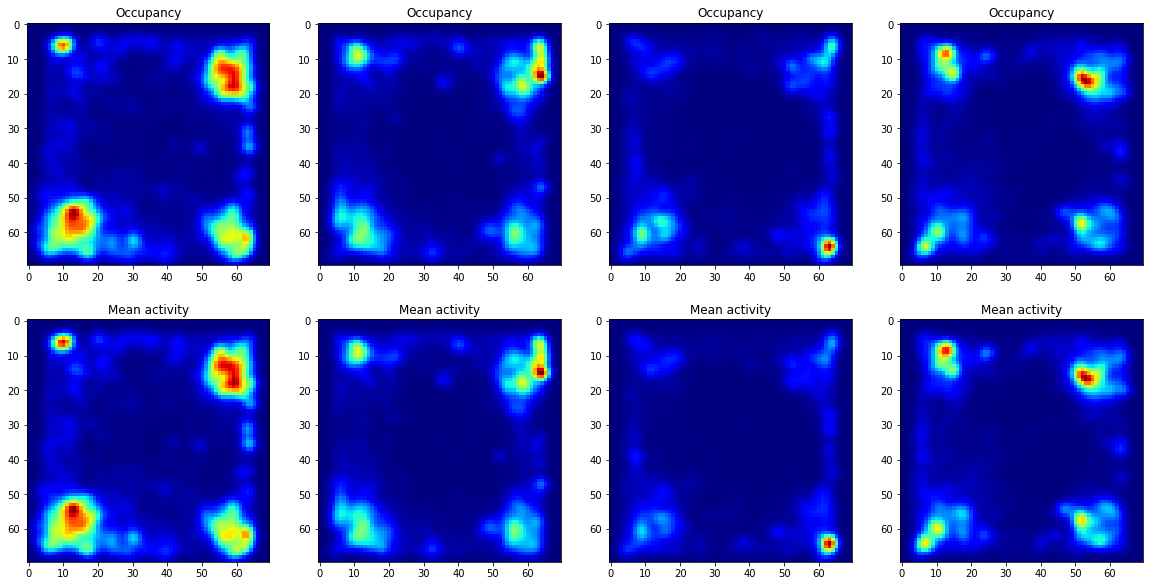

In [7]:
from scipy.ndimage import gaussian_filter
sigma = 1.5

figure = plt.figure(figsize=(20, 10))
gs = figure.add_gridspec(2, 4)

for day in range(len(behaviour_list)):
    
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = mean_activity_map(activity_list[day],tracking_list[day], binnumber = BINS)
    
    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    normalized_activity_map = activity_map_variable / occupancy
    normalized_activity_map =  gaussian_filter(normalized_activity_map, sigma)
    
    axes0 = figure.add_subplot(gs[0,day])
    axes1 = figure.add_subplot(gs[1, day])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_title('Occupancy')
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_title('Mean activity')

    

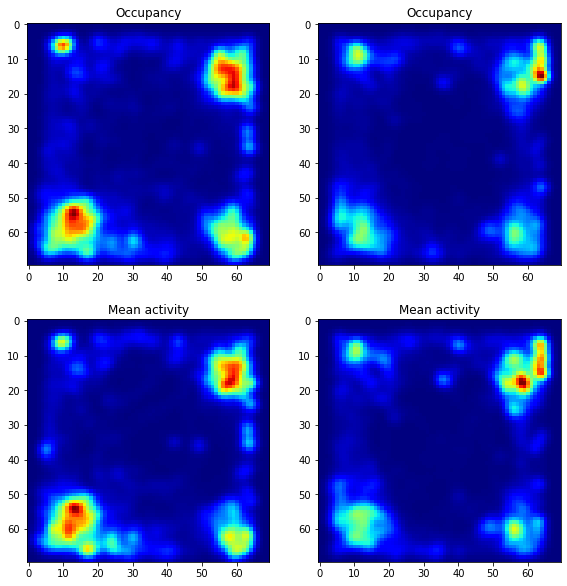

In [8]:
sigma = 1.5
NEURON = 10

figure = plt.figure(figsize=(20, 10))
gs = figure.add_gridspec(2, 4)

for day in range(len(tracking_list[day])):
    
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = neuron_activity_map(activity_list[day],tracking_list[day], binnumber = BINS, neuronID = NEURON)
#def neuron_activity_map(activity= None,tracking = None,binnumber = 70, neurinID = 0):

    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    
    axes0 = figure.add_subplot(gs[0,day])
    axes1 = figure.add_subplot(gs[1, day])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_title('Occupancy')
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_title('Mean activity')
    

In [9]:
# for each day creates a list that counts and saves times of different events.
events_day_list_1 = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    random_events = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter:
            events_list.append(start_counter)
            events_counter_list.append(counter)
            events_time_starts.append(i)
            start_counter = behaviour_list[day][i]
            counter = 1
        else:
            counter = counter + 1      
    events_day_list_1.append(events_list)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [11]:

## compute events duration for type of event. Here we create lists that we can access to know the duration of each ID event
## we will use this to balance the dataset

events_duration_list = []
total_duration_list = []

for day in range(len(behaviour_list)):
    events_duration_day = []
    total_duration_day = []
    for target in id_target:
        events = np.array(events_day_list_1[day])  # all events in a day
        events_counter = np.array(events_counter_day_list[day]) #duration of all day events
        events_time = np.array(events_time_starts_day[day]) # start time of events in day

        position_events = np.where(events == target)[0] # select events related to one specific ID
        events_duration_target = events_counter[position_events]   # take the duration of the events for that ID
        events_duration_day.append(events_duration_target)
        total_duration_day.append(np.sum(events_duration_target))
    events_duration_list.append(events_duration_day)
    total_duration_list.append(total_duration_day)

In [13]:
### Balancing the number of events for selected targets 

selection_target = [3,4]    # here we balcance the data only for this targets of behaviour

events_day_list= []         # create a list with the selected index of the ID-list to make a balanced selection
events_day_list_shuffle = []
events_number_list = []

for day in range(len(behaviour_list)):
    arg_min_target_time = np.argmin(total_duration_list[day])
    n_events = len(events_duration_list[day][arg_min_target_time])
    events_number_list.append(n_events)
    
    events_list = []
    events_list_copy = []
    for target in id_target:
        sorted_events = np.sort(events_duration_list[day][target]) #sort of events
        arg_sorted_events = np.argsort(events_duration_list[day][target]) #take the index sorted by duration of events
        longer_events = np.where(sorted_events > 1)[0]
        selected_events = arg_sorted_events[longer_events[0]:n_events]   # take only the first (sorter duration) events
        events_list.append(selected_events)                           # save the position of long and balanced events
        events_list_copy.append(selected_events.copy())               # make a copy of this events to create a shuffle list
        
    events_day_list.append(events_list)                              #this list contains index that are selected from the list of index of a specific target
    events_day_list_shuffle.append(events_list_copy)

In [16]:
## put all events together and take neural activity from each event
events_activity_pre_norm= []
events_duration_list = []
events_activity_pca = []
events_activity_cca = []


for day in range(len(behaviour_list)):
    target_activity = []
    target_activity_pca = []
    target_activity_cca = []
    events_duration_day = []
    for target in id_target:
        events = np.array(events_day_list_1[day])
        events_counter = np.array(events_counter_day_list[day])
        events_time = np.array(events_time_starts_day[day])

        all_events = np.where(events == target)[0]
        
        #print(all_events)
        #print(events_day_list[day][target])
        position_events = all_events[events_day_list[day][target]]
        
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        event_target = []
        event_target_pca = []
        event_target_cca = []
        #events_duration_target = np.zeros(len(events_duration),)
        events_duration_target = []
        for event in events_duration:
            if event > 2:
                local_activity = activity_list[day][:,time[i]-period:time[i]+period]
                local_activity_pca = activity_list_pca[day][:,time[i]-period:time[i]+period]
                local_activity_cca = activity_list_cca[day][time[i]-period:time[i]+period,:].T
                event_target.append(local_activity)
                event_target_pca.append(local_activity_pca)
                event_target_cca.append(local_activity_cca)
                #events_duration_target[i]=1
                events_duration_target.append(events_duration[i])
            i = i + 1
        target_activity.append(event_target)
        target_activity_pca.append(event_target_pca)
        target_activity_cca.append(event_target_cca)
        events_duration_day.append(events_duration_target)
    events_activity_pre_norm.append(target_activity)
    events_duration_list.append(events_duration_day)
    events_activity_pca.append(target_activity_pca)
    events_activity_cca.append(target_activity_cca)


    

In [ ]:
# z-score the traces
events_activity = []
for day in range(len(behaviour_list)):
    target_activity = []
    for target in id_target:
        mean_z_score = np.mean(events_activity_pre_norm[day][target],axis=0)
        #print(mean_z_score.shape)
        std_z_score = np.std(events_activity_pre_norm[day][target],axis=0)
        events_target = []
        for event in range(len(events_activity_pre_norm[day][target])):
            new_activity = (events_activity_pre_norm[day][target][event]-mean_z_score)/std_z_score
            #new_activity = events_activity_pre_norm[day][target][event]
            events_target.append(new_activity)
        target_activity.append(events_target)
    events_activity.append(target_activity)

In [18]:
events_activity = events_activity_pre_norm




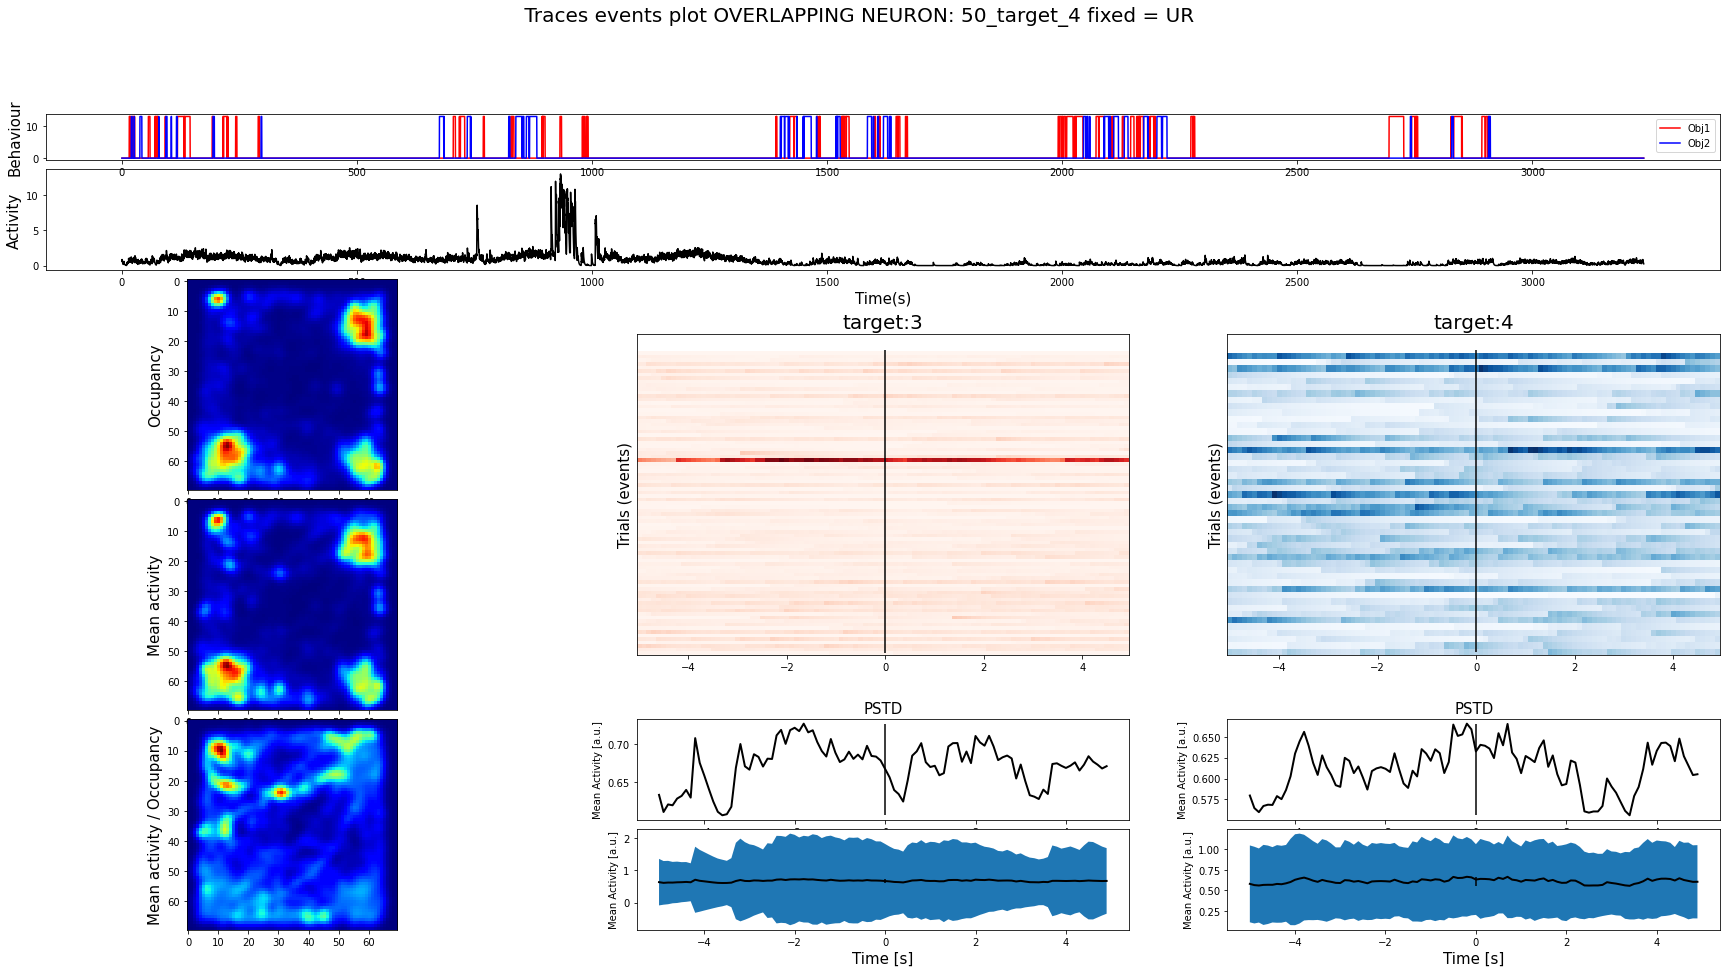

In [26]:
    ### Select a cell
    day = 0
    #for NEURON in range(100):
    NEURON = 50
    figure = plt.figure()
    gs = plt.GridSpec(15, 3)

    axes = figure.add_subplot(gs[1:3, 0:3])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),activity_list[day][NEURON,:],color = 'k')
    axes.set_xlabel('Time(s)',fontsize = 15)
    axes.set_ylabel('Activity',fontsize = 15)

    axes = figure.add_subplot(gs[0, 0:3])
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==3)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'r')
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==4)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'b')
    axes.set_ylabel('Behaviour',fontsize = 15)
    axes.legend(['Obj1','Obj2'])


    color_code = ['Reds','Blues']
    j = 1
    for target in selection_target:
        axes = figure.add_subplot(gs[4:10, j])
        color = events_duration_list[day][target]
        neuron_trial_activity = np.zeros((len(events_activity[day][target]),events_activity[day][3][0].shape[1]))
        for trial in range(len(events_activity[day][target])):
            neuron_trial_activity[trial,:] = events_activity_pre_norm[day][target][trial][NEURON,:]
            
        C_0 = neuron_trial_activity.copy()
        time_axis = np.arange(-period,period)/10
        neurons_axis = np.arange(0,C_0.shape[0])
        mesh = axes.pcolormesh(time_axis,neurons_axis, C_0, cmap=color_code[j-1],shading='auto')
            
#         C_0[0] += C_0[0].min()
#         for i in range(0, len(C_0)):
#             #C_0[i] += C_0[i].min() + C_0[:i].max()
#             C_0[i]= C_0[i]/(C_0[i].max()-C_0[i].min()) + i
#             if color[i]==1:
#                 axes.plot(np.arange(-period,period)/10,C_0[i],color_code[j-1])
#             else:
#                 axes.plot(np.arange(-period,period)/10,C_0[i],'k')
        #axes.set_xlabel('Time [s]',fontsize = 15)
    
        axes.set_yticks([])
        axes.set_ylabel('Trials (events)', fontsize = 15)
        axes.set_title('target:' + f'{target}', fontsize = 20)
        axes.vlines(0,0, C_0.shape[0], color = 'k')
        
        axes_1 = figure.add_subplot(gs[11:13, j])
        pstd = np.mean(neuron_trial_activity,axis = 0)
        time_axis = np.arange(-period,period)/10
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.set_title('PSTD', fontsize = 15)
        axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)

        axes_1 = figure.add_subplot(gs[13:15, j])
        pstd_std = np.std(neuron_trial_activity,axis = 0)
        uperbound = pstd + pstd_std
        lowerbound = pstd - pstd_std
        time_axis = np.arange(-period,period)/10
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        axes_1.set_xlabel('Time [s]',fontsize = 15)
        axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)
        j=j+1


    sigma = 1.5
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = neuron_activity_map(activity_list[day],tracking_list[day], binnumber = BINS, neuronID = NEURON)
    normalized_activity_map = np.zeros_like(activity_map_variable)
    normalized_activity_map[np.where(occupancy)] = activity_map_variable[np.where(occupancy)]/occupancy[np.where(occupancy)]
    
    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    normalized_activity_map = gaussian_filter(normalized_activity_map,sigma)
    
    axes0 = figure.add_subplot(gs[3:7,0])
    axes1 = figure.add_subplot(gs[7:11, 0])
    axes2 = figure.add_subplot(gs[11:15, 0])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_ylabel('Occupancy', fontsize = 15)
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_ylabel('Mean activity',fontsize = 15)
    axes2.imshow(normalized_activity_map, cmap = 'jet')
    axes2.set_ylabel('Mean activity / Occupancy', fontsize = 15)
    
    
    #axes = figure.add_subplot(gs[3:10,0])
    #axes.imshow(activity_map_variable, cmap='jet')
    #axes.set_title('Mean Spatial Neural activity')

    figure.set_size_inches([30., 15])

    figure.suptitle(' Traces events plot ' + task +' NEURON: '+f'{NEURON}'+'_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    figure_name = figure_path + 'traces_events_neuron_'+f'{NEURON}'+'_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
    figure.savefig(figure_name)
    #plt.close()

    

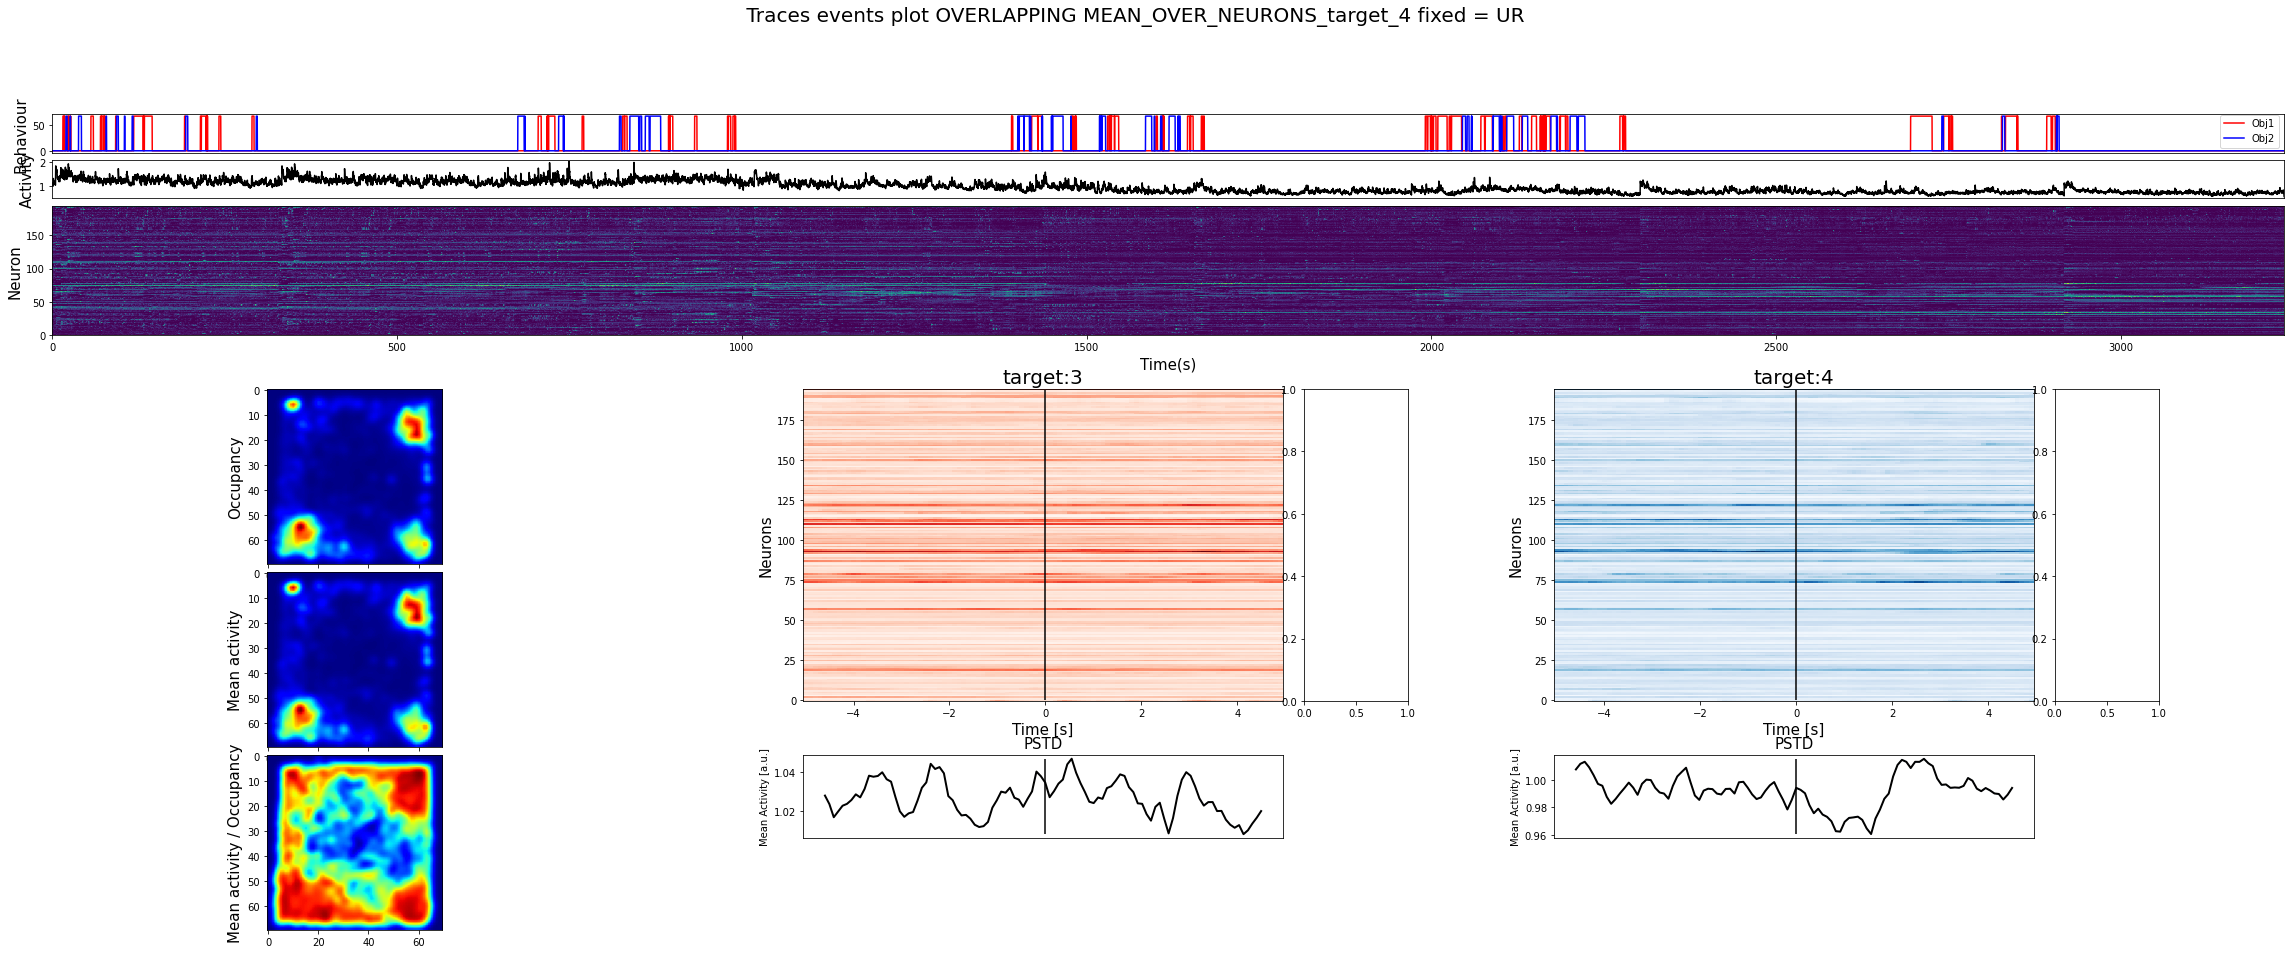

In [21]:
    ### Select a cell
    figure = plt.figure()
    gs = plt.GridSpec(18, 18)

    axes = figure.add_subplot(gs[1:2, 0:18])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),np.mean(activity_list[day],axis=0),color = 'k')
    axes.set_ylabel('Activity',fontsize = 15)
    axes.set_xticks([])
    axes.set_xlim([0,len(behaviour_list[day])/10])

    axes = figure.add_subplot(gs[0, 0:18])
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==3)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'r')
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==4)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'b')
    axes.set_ylabel('Behaviour',fontsize = 15)
    axes.legend(['Obj1','Obj2'])
    axes.set_xticks([])
    axes.set_xlim([0,len(behaviour_list[day])/10])

    
    axes = figure.add_subplot(gs[2:5, 0:18])
    time_axis = np.arange(0,len(behaviour_list[day]))/10
    neurons_axis = np.arange(0,events_activity[day][target][0].shape[0])
    activity = np.zeros((events_activity[day][target][0].shape[0],len(behaviour_list[day])))
    for i in neurons_axis:
        activity[i,:] = activity_list[day][i,:]/(np.max(activity_list[day][i,:])-np.mean(activity_list[day][i,:]))
    
    mesh = axes.pcolormesh(time_axis,neurons_axis,activity, cmap='viridis',shading='auto')
    axes.set_xlabel('Time(s)',fontsize = 15)
    axes.set_ylabel('Neuron',fontsize = 15)

    color_code = ['Reds','Blues']
    #color_code = ['r','b']
    columns = [np.arange(6,11)]
    j=0
    columns.append(np.arange(12,17))
    for target in selection_target:
        axes = figure.add_subplot(gs[6:13, 6*(j+1):6*(j+1)+4])
        trial_activity = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        for neuron in range(events_activity[day][target][0].shape[0]):
            neuron_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            for trial in range(len(events_activity[day][target])):
                neuron_trial_activity += events_activity[day][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
            neuron_trial_activity = neuron_trial_activity / len(events_activity[day][target])
            trial_activity[neuron,:] = neuron_trial_activity
            
        C_0 = trial_activity.copy()
        time_axis = np.arange(-period,period)/10
        neurons_axis = np.arange(0,C_0.shape[0])
        #time_axis, neurons_axis = np.meshgrid(time_axis, neurons_axis)
        
        #surf = axes.plot_surface(time_axis, neurons_axis, C_0, cmap=color_code[j-1],linewidth=0, antialiased=False)
        mesh = axes.pcolormesh(time_axis,neurons_axis, C_0, cmap=color_code[j],shading='auto')
        #axes.imshow(neurons_axis,time_axis,C_0, cmap = color_code[j-1])
#         C_0[0] += C_0[0].min()
#         for i in range(0, C_0.shape[0]):
#             #C_0[i] += C_0[i].min() + C_0[:i].max()
#             C_0[i]= C_0[i]/(C_0[i].max()-C_0[i].min()) + i
#             axes.plot(np.arange(-period,period)/10,C_0[i],color_code[j])
        axes.set_xlabel('Time [s]',fontsize = 15)
    
        #axes.set_yticks()
        axes.set_xlabel('Time [s]', fontsize = 15)
        axes.set_ylabel('Neurons', fontsize = 15)
        axes.set_title('target:' + f'{target}', fontsize = 20)
        axes.vlines(0,0, neuron, color = 'k')
        
        axes_1 = figure.add_subplot(gs[14:16,6*(j+1):6*(j+1)+4])
        pstd = np.mean(trial_activity,axis = 0)
        pstd_std_error = np.std(neuron_trial_activity,axis = 0)/trial_activity.shape[0]
        time_axis = np.arange(-period,period)/10
        uperbound = pstd + pstd_std_error
        lowerbound = pstd - pstd_std_error
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])        
        axes_1.set_title('PSTD', fontsize = 15)
        axes_1.vlines(0,min(uperbound), max(lowerbound),color = 'k',linestyle = '-')
        axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)
        axes_1.set_xticks([])

#         axes_1 = figure.add_subplot(gs[16:18, 6*(j+1):6*(j+1)+4])
#         pstd_std = np.std(neuron_trial_activity,axis = 0)
#         uperbound = pstd + pstd_std
#         lowerbound = pstd - pstd_std
#         time_axis = np.arange(-period,period)/10
#         axes_1.plot(time_axis, pstd,'k', linewidth = 2)
#         axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
#         axes_1.vlines(0,np.min(pstd-pstd_std), np.max(pstd+pstd_std),color = 'k',linestyle = 'dotted')
#         axes_1.set_xlabel('Time [s]',fontsize = 15)
#         axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)
        
        axes_1 = figure.add_subplot(gs[6:13,6*(j+1)+4])
        pop_vect = np.mean(trial_activity,axis = 1)
        #axes_1.plot(pop_vect,'k', linewidth = 2)

        #axes_1.set_title('PSTD', fontsize = 15)
        #axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        #axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)
        
        #axes_1.set_xticks([])
        #from matplotlib import transforms
        #base = plt.gca().transData
        #rot = transforms.Affine2D().rotate_deg(90)

        ## define transformed line
        #axes_1.plot(np.arange(0,neuron+1),pop_vect,'k',transform= base + rot)
        j=j+1
        

    sigma = 1.5
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = mean_activity_map(activity_list[day],tracking_list[day], binnumber = BINS)
    normalized_activity_map = np.zeros_like(activity_map_variable)
    normalized_activity_map[np.where(occupancy)] = activity_map_variable[np.where(occupancy)]/occupancy[np.where(occupancy)]
    
    normalized_activity_map = gaussian_filter(normalized_activity_map,sigma)
    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    
    axes0 = figure.add_subplot(gs[6:10,0:5])
    axes1 = figure.add_subplot(gs[10:14, 0:5])
    axes2 = figure.add_subplot(gs[14:18, 0:5])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_ylabel('Occupancy', fontsize = 15)
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_ylabel('Mean activity',fontsize = 15)
    axes2.imshow(normalized_activity_map, cmap = 'jet')
    axes2.set_ylabel('Mean activity / Occupancy', fontsize = 15)
    
    
    #axes = figure.add_subplot(gs[3:10,0])
    #axes.imshow(activity_map_variable, cmap='jet')
    #axes.set_title('Mean Spatial Neural activity')

    figure.set_size_inches([40., 15])

    figure.suptitle(' Traces events plot ' + task +' MEAN_OVER_NEURONS_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    figure_name = figure_path + 'traces_events_neuron_'+f'{NEURON}'+'_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
    figure.savefig(figure_name)
    #plt.close()


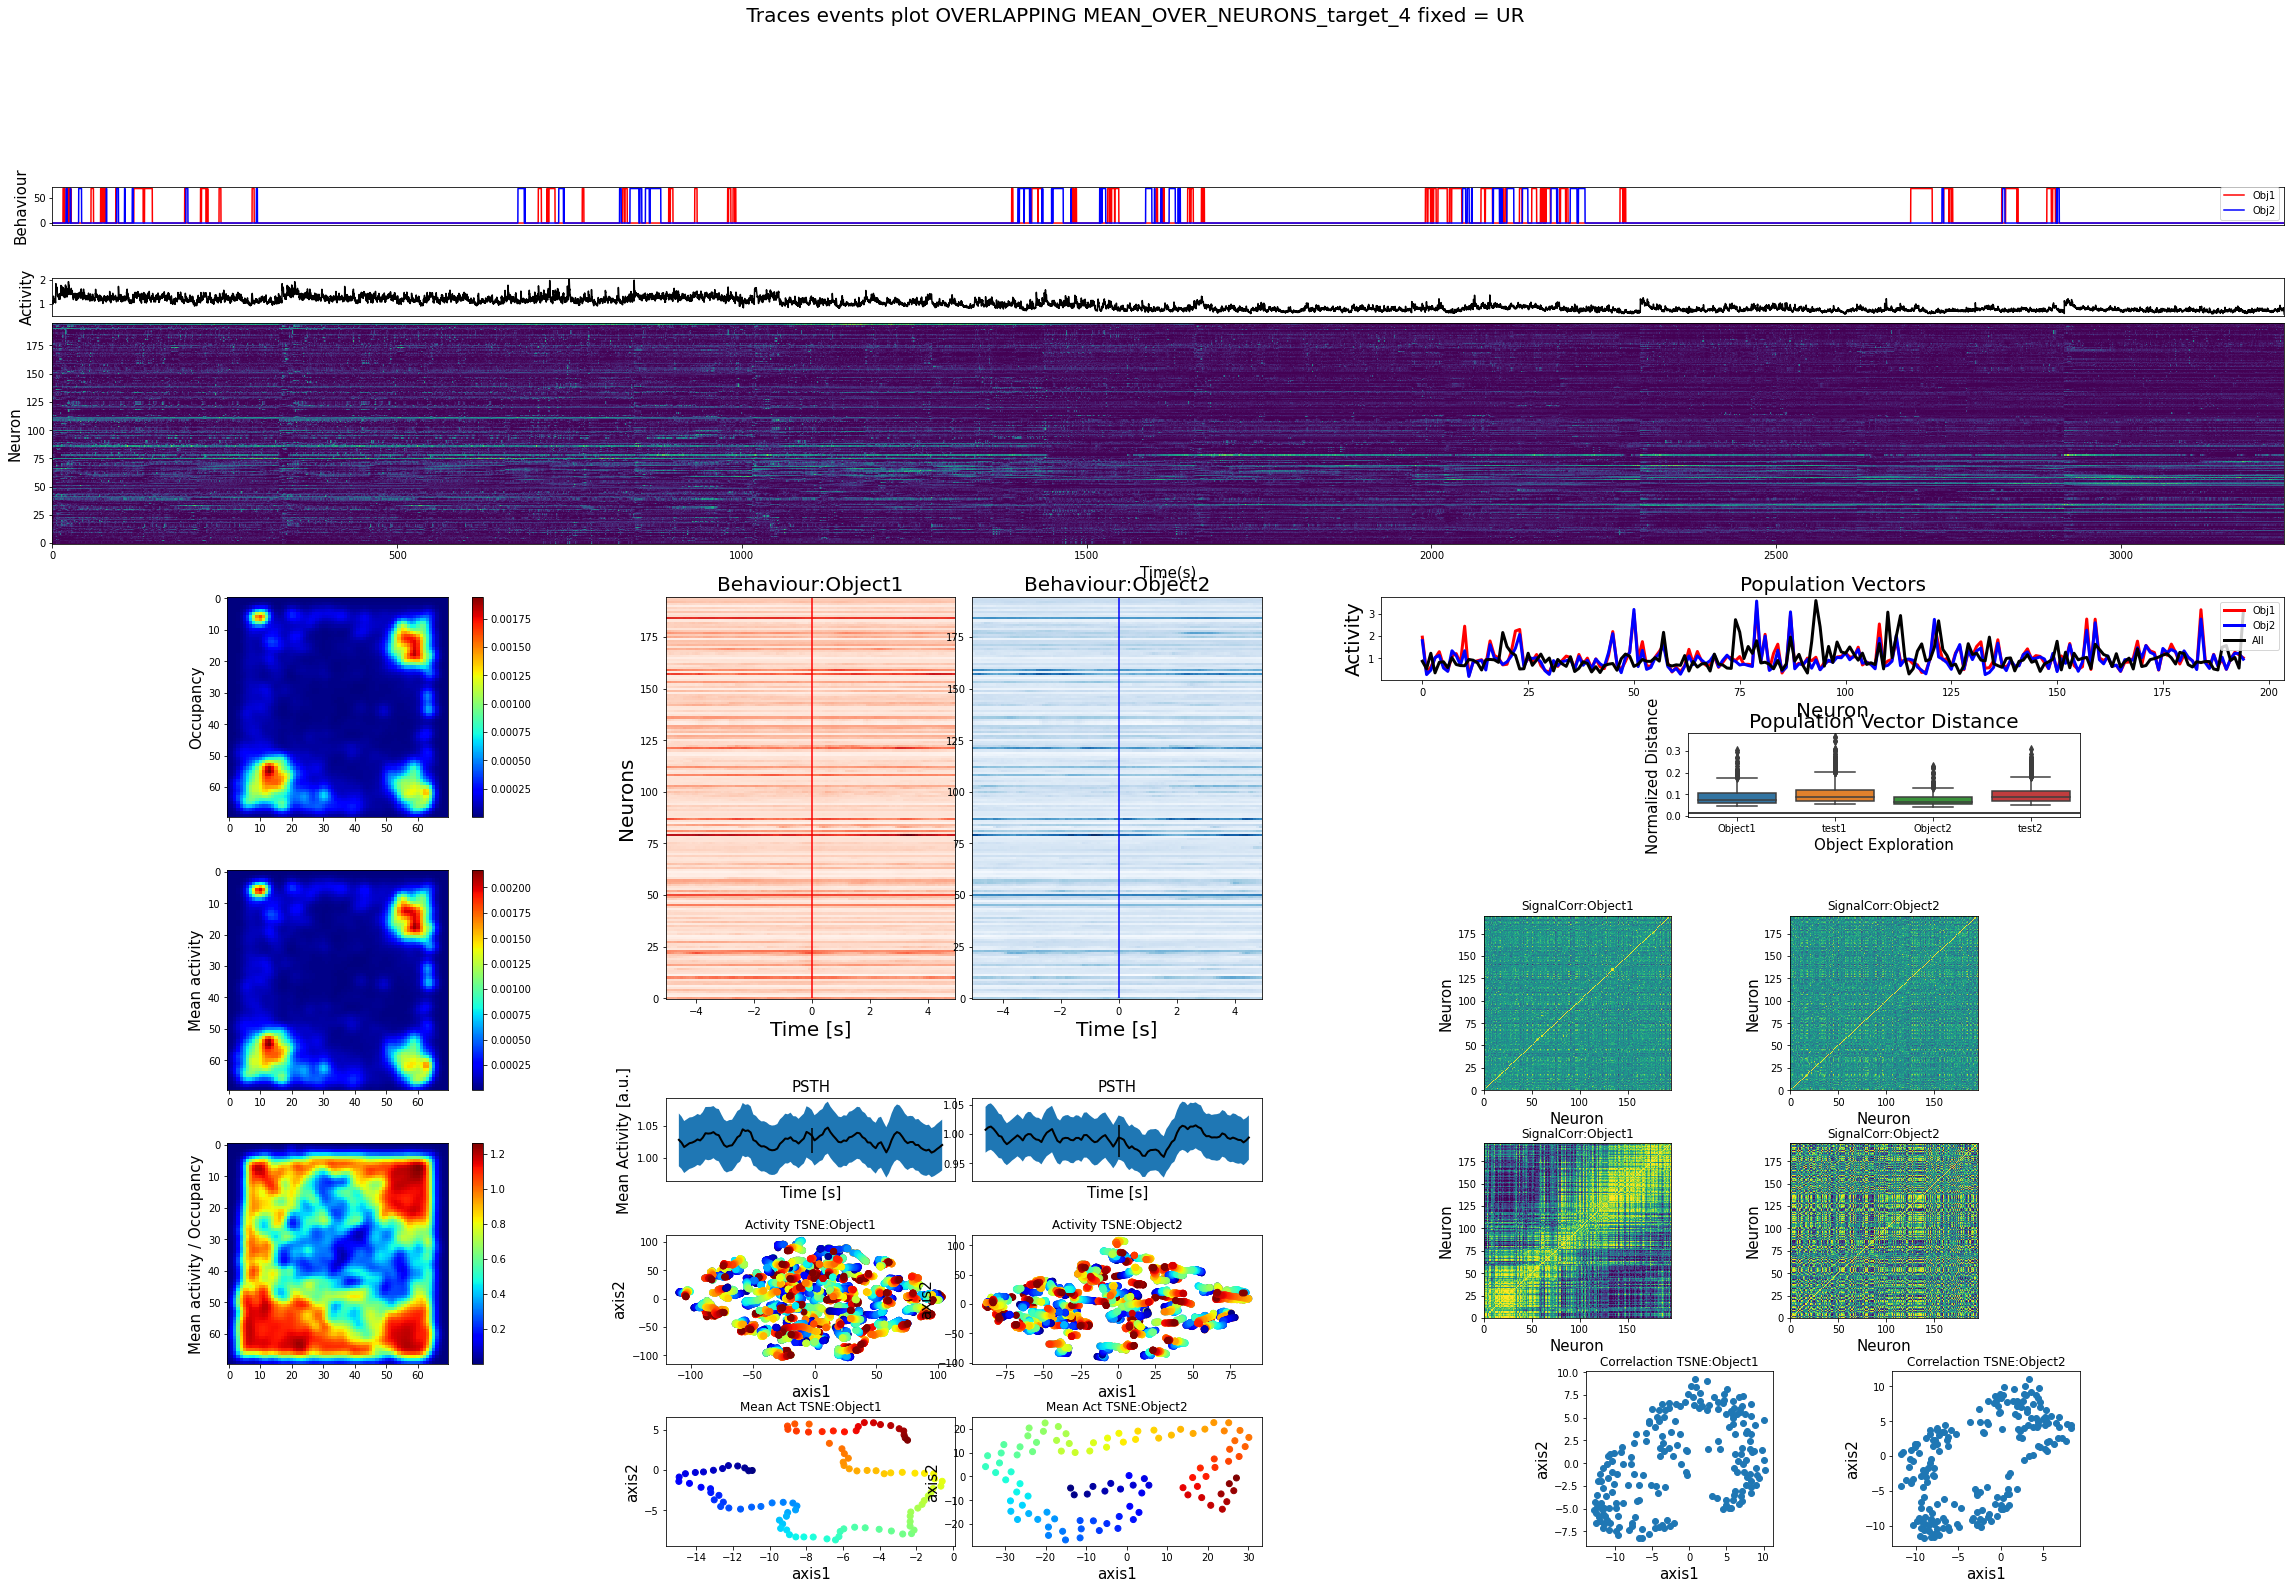

In [22]:
    ### Select a cell
    behaviour = ['Object1','Object2']
    events_activity = events_activity_pre_norm
    vmin_corr = -1
    vmax_corr = 1

    figure = plt.figure()
    gs = plt.GridSpec(30, 22)

    axes = figure.add_subplot(gs[2, 0:22])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),np.mean(activity_list[day],axis=0),color = 'k')
    axes.set_ylabel('Activity',fontsize = 15)
    axes.set_xticks([])
    axes.set_xlim([0,len(behaviour_list[day])/10])

    axes = figure.add_subplot(gs[0, 0:22])
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==3)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'r')
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==4)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'b')
    axes.set_ylabel('Behaviour',fontsize = 15)
    axes.legend(['Obj1','Obj2'])
    axes.set_xticks([])
    axes.set_xlim([0,len(behaviour_list[day])/10])

#     axes = figure.add_subplot(gs[1, 0:22])
#     behaviour1 = np.zeros((len(behaviour_list_copy[day]),))
#     behaviour1[np.where(behaviour_list_copy[day]==3)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'g')
#     behaviour1 = np.zeros((len(behaviour_list[day]),))
#     behaviour1[np.where(behaviour_list_copy[day]==4)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'orange')
#     behaviour1[np.where(behaviour_list_copy[day]==5)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'r')
#     behaviour1[np.where(behaviour_list_copy[day]==6)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'cyan')
#     axes.set_ylabel('Behaviour',fontsize = 15)
#     axes.legend(['UR','UL','LR','LL']) ###verify this
#     axes.set_xticks([])
#     axes.set_xlim([0,len(behaviour_list[day])/10])
    
    axes = figure.add_subplot(gs[3:8, 0:22])
    time_axis = np.arange(0,len(behaviour_list[day]))/10
    neurons_axis = np.arange(0,events_activity[day][target][0].shape[0])
    activity = np.zeros((events_activity[day][target][0].shape[0],len(behaviour_list[day])))
    for i in neurons_axis:
        activity[i,:] = activity_list[day][i,:]/(np.max(activity_list[day][i,:])-np.mean(activity_list[day][i,:]))
    
    mean_pop_vector = np.zeros((activity_list[day].shape[0],))
    mesh = axes.pcolormesh(time_axis,neurons_axis,activity, cmap='viridis',shading='auto')
    axes.set_xlabel('Time(s)',fontsize = 15)
    axes.set_ylabel('Neuron',fontsize = 15)

    color_code = ['Reds','Blues']
    color_code_pop = ['r','b']
    j=0
    
    ### definition of subplots that have plots from different exploratory behaviour
    axes_pop_vector = figure.add_subplot(gs[9:11,13:22])
    
    pop_vector_distance = []
    pop_vect_list = []
    mean_pop_vector_list = []

    for target in selection_target:
        
        ### subplots for mean activity 
        axes = figure.add_subplot(gs[9:18, 3*(j+1)+3:3*(j+1)+6])
        
        trial_activity = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        trial_activity_complete = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*10+1))
        trial_activity_all_data = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*2*period+1))
        trial_activity_pca = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        
        ### generate matrix with mean activity and entire trial repetitions activity
        for neuron in range(events_activity[day][target][0].shape[0]):
            neuron_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            component_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            init = 0
            init2=0
            for trial in range(len(events_activity[day][target])):
                neuron_trial_activity += events_activity[day][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
                component_trial_activity +=events_activity_pca[day][target][trial][neuron,:]
                trial_activity_all_data[neuron,init2:init2+2*period]= events_activity[day][target][trial][neuron,:]
                trial_activity_complete[neuron,init:init+10] = events_activity[day][target][trial][neuron,period:period+10]
                init = init+10
                init2=init2+2*period
            neuron_trial_activity = neuron_trial_activity / len(events_activity[day][target])
            component_trial_activity = component_trial_activity / len(events_activity[day][target])
            trial_activity[neuron,:] = neuron_trial_activity
            trial_activity_pca[neuron,:] = component_trial_activity
        
        if j == 0:
            max_position = np.argmax(trial_activity[:,period:period+10],axis = 1)
            firing_order = np.argsort(max_position)
        C_0 = trial_activity.copy()
        C_0 = C_0[firing_order,:]
        trial_activity_complete = trial_activity_complete[firing_order,:]

        mean_pop_vector1 = np.mean(trial_activity,axis =1)
        mean_pop_vector_list.append(mean_pop_vector1)
        mean_pop_vector += mean_pop_vector1
        
        time_axis = np.arange(-period,period)/10
        neurons_axis = np.arange(0,C_0.shape[0])        
        mesh = axes.pcolormesh(time_axis,neurons_axis, C_0, cmap=color_code[j],shading='auto')
        axes.set_xlabel('Time [s]',fontsize = 20)
    
        #axes.set_yticks()
        axes.set_xlabel('Time [s]', fontsize = 20)
        if j==0:
            axes.set_ylabel('Neurons', fontsize = 20)
        axes.set_title('Behaviour:' + behaviour[j], fontsize = 20)
        axes.vlines(0,0, neuron, color = color_code_pop[j])
                
        
        axes_1 = figure.add_subplot(gs[20:22,3*(j+1)+3:3*(j+1)+6])
        pstd = np.mean(trial_activity,axis = 0)
        pstd_std_error = np.std(trial_activity,axis = 0)/np.sqrt(trial_activity.shape[0])
        uperbound = pstd + pstd_std_error
        lowerbound = pstd - pstd_std_error
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_1.set_title('PSTH', fontsize = 15)
        axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        if j==0:
            axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 15)
        axes_1.set_xticks([])
        axes_1.set_xlabel('Time [s]',fontsize = 15)
        
        pop_vect = np.mean(C_0[:,period:period+10],axis = 1)
        axes_pop_vector.plot(np.arange(0,neuron+1),pop_vect, color_code_pop[j],linewidth = 3)
        axes_pop_vector.set_xlabel('Neuron',fontsize = 20)
        axes_pop_vector.set_ylabel('Activity', fontsize = 20)
        pop_vect_list.append(pop_vect)
        
        corr_matrix2 = stats.corr_matrix(neural_activity = trial_activity_complete)
        axes_corr = figure.add_subplot(gs[16:20,14+3*j:16+3*j])
        #axes_corr = figure.add_subplot(gs[17:21,3*(j+1):3*(j+1)+3])
        #axes_corr = figure.add_subplot(gs[22:26,3*(j+1):3*(j+1)+3])
        #axes_corr.imshow(corr_matrix2, cmap = 'viridis', origin = 'lower')
        mesh_corr = axes_corr.pcolormesh(corr_matrix2, cmap = 'viridis')
        axes_corr.set_xlabel('Neuron',fontsize = 15)
        axes_corr.set_ylabel('Neuron',fontsize = 15)
        axes_corr.set_title('SignalCorr:' + behaviour[j])
        mesh_corr.set_clim(vmin_corr,vmax_corr)


        corr_matrix = stats.corr_matrix(neural_activity = C_0[:,period:period+10])
        axes_corr = figure.add_subplot(gs[21:25,14+3*j:16+3*j])
        #axes_corr = figure.add_subplot(gs[22:26,3*(j+1):3*(j+1)+3])
        #axes_corr.imshow(corr_matrix, cmap = 'viridis', origin = 'lower')
        mesh_corr = axes_corr.pcolormesh(corr_matrix, cmap = 'viridis')
        axes_corr.set_xlabel('Neuron',fontsize = 15)
        axes_corr.set_ylabel('Neuron',fontsize = 15)
        axes_corr.set_title('SignalCorr:' + behaviour[j])
        mesh_corr.set_clim(vmin_corr,vmax_corr)

        tsne_components = 2
        events_embedded = TSNE(n_components=tsne_components).fit_transform(corr_matrix)
        axes_corr = figure.add_subplot(gs[26:30,15+3*j:17+3*j])
        axes_corr.scatter(events_embedded[:,0],events_embedded[:,1])#, cmap = 'viridis', origin = 'lower')
        axes_corr.set_xlabel('axis1',fontsize = 15)
        axes_corr.set_ylabel('axis2',fontsize = 15)
        axes_corr.set_title('Correlaction TSNE:' + behaviour[j])  
        
        events_embedded_temporal = TSNE(n_components=tsne_components).fit_transform(trial_activity_all_data.T)
        axes_corr = figure.add_subplot(gs[23:26,3*(j+1)+3:3*(j+1)+6])
        color1 = np.linspace(0, 20, 2*period)
        repetitions = len(events_activity[day][target])
        repeat_color =  np.tile(color1, (repetitions, 1)).flatten()
        axes_corr.scatter(events_embedded_temporal[:-1,0],events_embedded_temporal[:-1,1],c = repeat_color, cmap = cmap)
        axes_corr.set_xlabel('axis1',fontsize = 15)
        axes_corr.set_ylabel('axis2',fontsize = 15)
        axes_corr.set_title('Activity TSNE:' + behaviour[j])   
        
        events_embedded_mean_temporal = TSNE(n_components=tsne_components).fit_transform(trial_activity.T)
        axes_corr = figure.add_subplot(gs[27:30,3*(j+1)+3:3*(j+1)+6])
        color1 = np.linspace(0, 20, 2*period)
        axes_corr.scatter(events_embedded_mean_temporal[:,0],events_embedded_mean_temporal[:,1],c = color1, cmap = cmap)
        axes_corr.set_xlabel('axis1',fontsize = 15)
        axes_corr.set_ylabel('axis2',fontsize = 15)
        axes_corr.set_title('Mean Act TSNE:' + behaviour[j])   
        
        euclidean_distance = np.zeros((len(events_activity[day][target])*10,))
        for time_point in range(len(euclidean_distance)):
            euclidean_distance[time_point] = np.linalg.norm(pop_vect - trial_activity_complete[:,time_point])/ trial_activity.shape[0]
        pop_vector_distance.append(euclidean_distance)
   
        euclidean_distance = np.zeros((len(events_activity[day][target])*2*period,))
        for time_point in range(len(euclidean_distance)):
            euclidean_distance[time_point] = np.linalg.norm(pop_vect- trial_activity_all_data[:,time_point]) / trial_activity.shape[0]
        pop_vector_distance.append(euclidean_distance)
           
        j=j+1
    
    mean_pop_vector = mean_pop_vector/2
    axes_pop_vector.plot(np.arange(0,neuron+1),mean_pop_vector,'k',linewidth = 3) 
    axes_pop_vector.legend(['Obj1','Obj2','All'])
    axes_pop_vector.set_title('Population Vectors', fontsize = 20)
    
    label = ['Object1','test1','Object2','test2' ]
    axes_distance = figure.add_subplot(gs[12:14,16:20])
    axes_distance.set_title('Population Vector Distance',fontsize = 20)
    representation_distance = np.linalg.norm(pop_vect_list[0]-pop_vect_list[1])/ trial_activity.shape[0]
    axes_distance= sns.boxplot(data = pop_vector_distance, orient = 'v')
    axes_distance.axhline(representation_distance,color = 'k')
    axes_distance.set_xticklabels(label)
    axes_distance.set_xlabel('Object Exploration', fontsize = 15)
    axes_distance.set_ylabel('Normalized Distance', fontsize = 15)    
    
    
    sigma = 1.5
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = mean_activity_map(activity_list[day],tracking_list[day], binnumber = BINS)
    normalized_activity_map = np.zeros_like(activity_map_variable)
    normalized_activity_map[np.where(occupancy)] = activity_map_variable[np.where(occupancy)]/occupancy[np.where(occupancy)]
    
    normalized_activity_map = gaussian_filter(normalized_activity_map,sigma)
    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    
    axes0 = figure.add_subplot(gs[9:14,0:5])
    axes1 = figure.add_subplot(gs[15:20, 0:5])
    axes2 = figure.add_subplot(gs[21:26, 0:5])

    ax0 = axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_ylabel('Occupancy', fontsize = 15)
    figure.colorbar(ax0, ax=axes0)
    
    ax1 = axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_ylabel('Mean activity',fontsize = 15)
    figure.colorbar(ax1, ax=axes1)

    ax2 = axes2.imshow(normalized_activity_map, cmap = 'jet')
    axes2.set_ylabel('Mean activity / Occupancy', fontsize = 15)
    figure.colorbar(ax2, ax=axes2)

    figure.set_size_inches([40., 25])

    figure.suptitle(' Traces events plot ' + task +' MEAN_OVER_NEURONS_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    
    figure_name = figure_path + 'traces_events_neuron_'+f'{NEURON}'+'_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_version2.png'
    figure.savefig(figure_name)
    

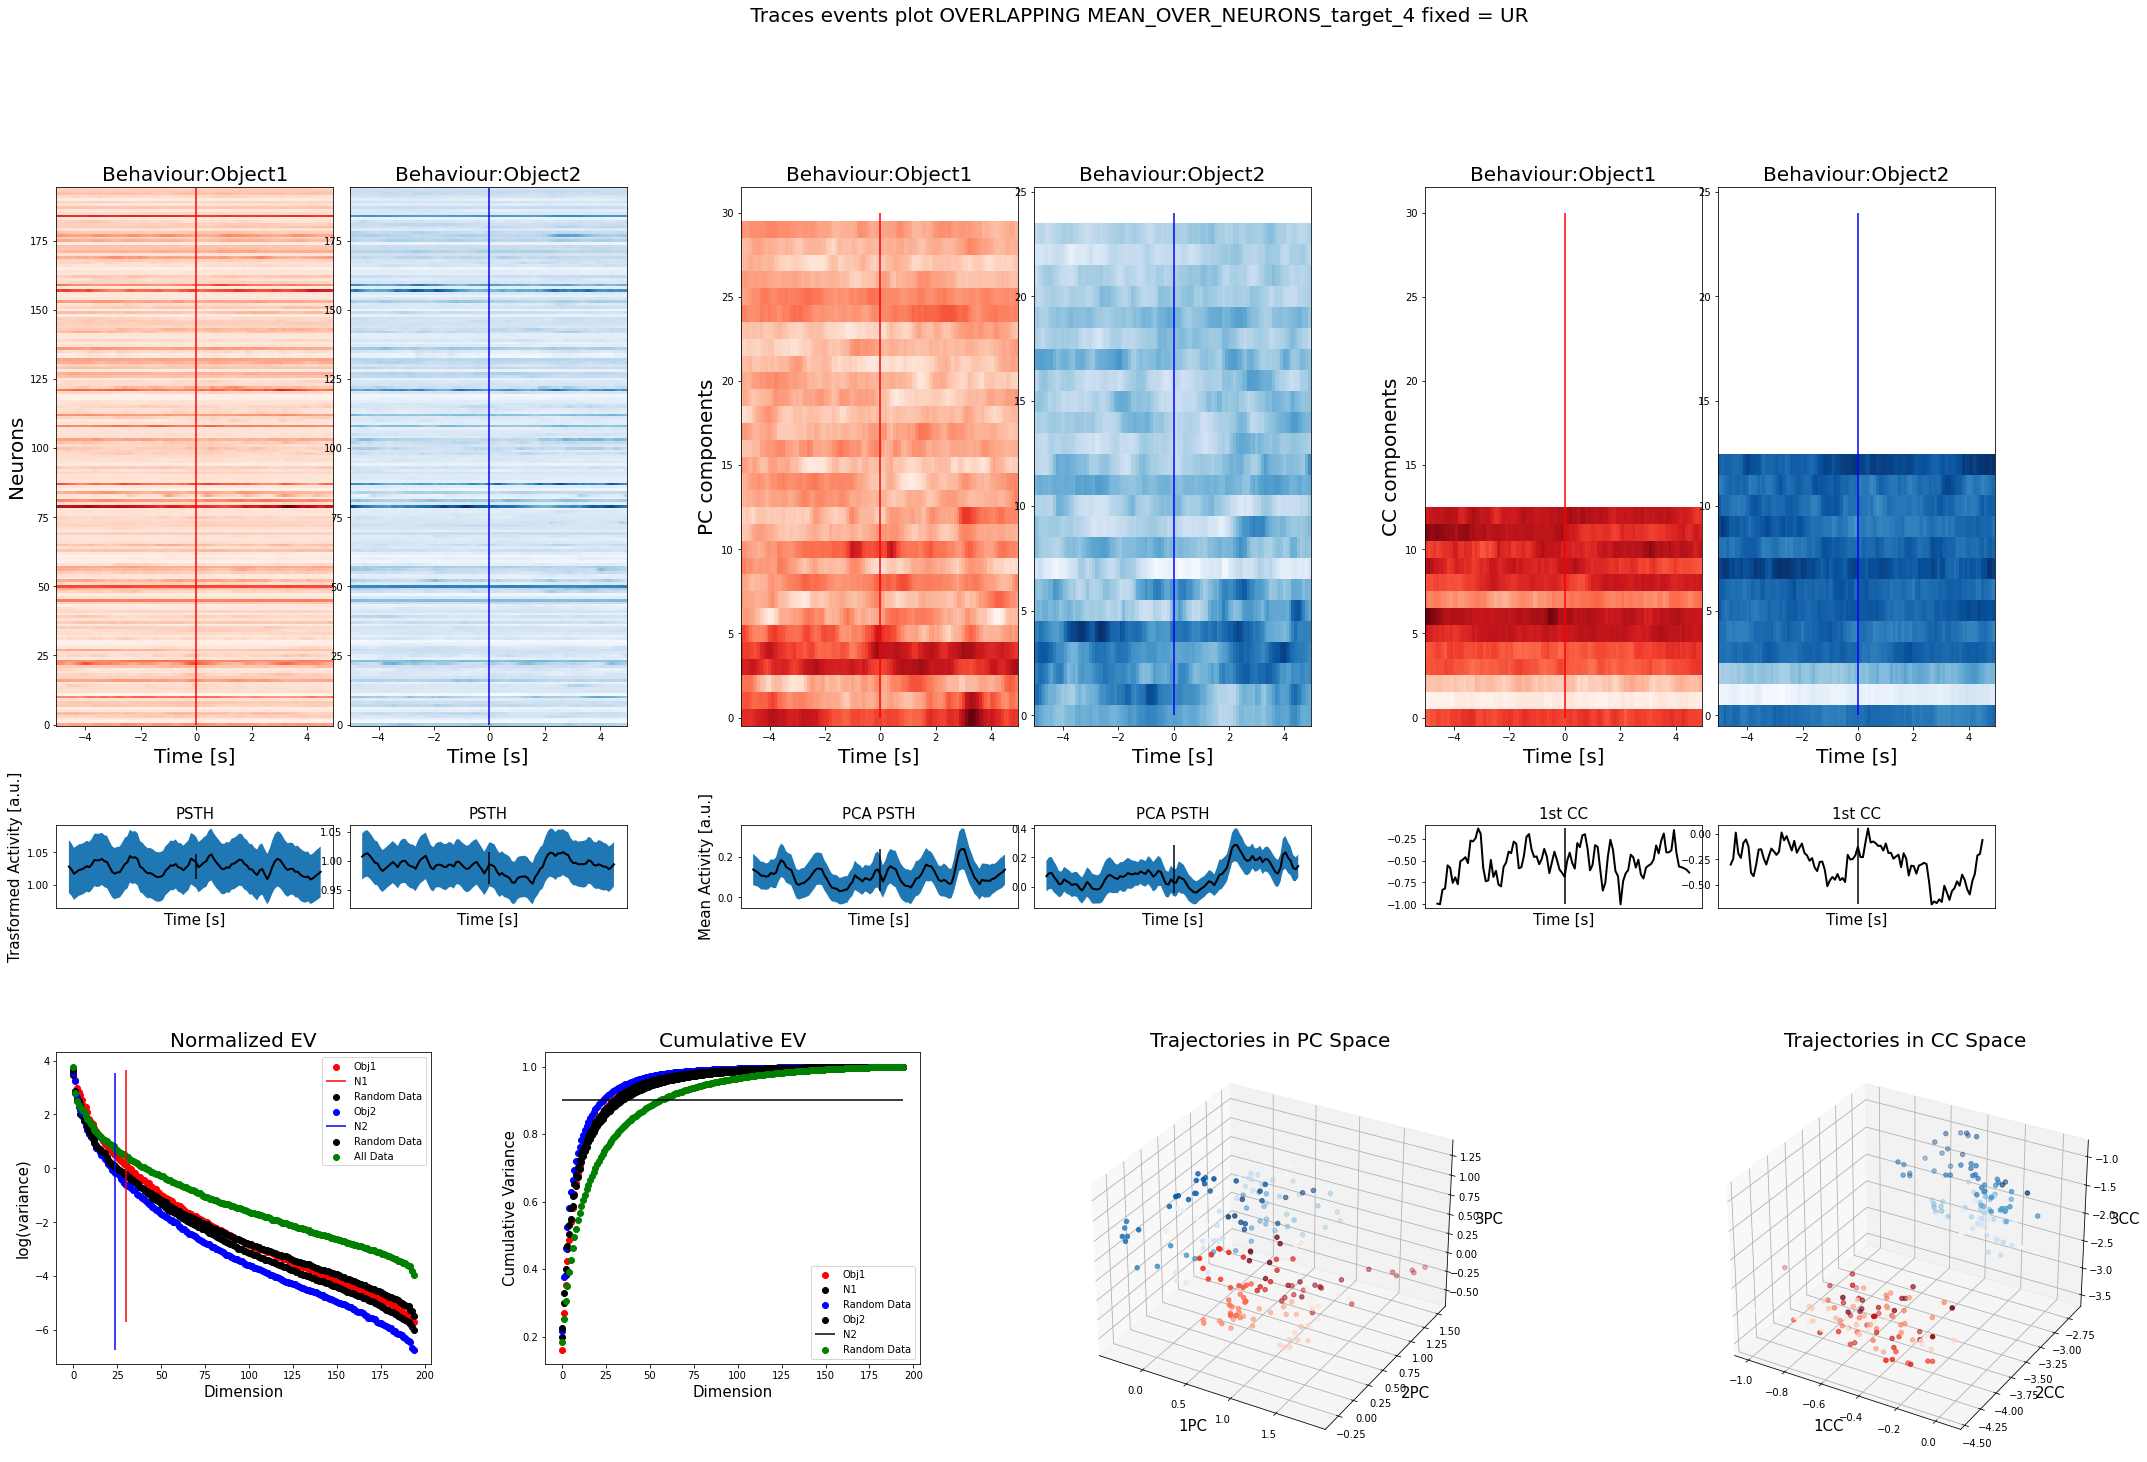

In [27]:
    ### Select a cell
    behaviour = ['Object1','Object2']

    figure = plt.figure()
    gs = plt.GridSpec(30, 23)

    color_code = ['Reds','Blues']
    color_code_pop = ['r','b']
    j=0
    CAPTURED_VARIANCE= 0.90
    
    ### definition of subplots that have plots from different exploratory behaviour
    #axes_pop_vector = figure.add_subplot(gs[17:19,3:9])
    axes_pca_variance = figure.add_subplot(gs[19:26,0:4])
    axes_pca_cum_variance = figure.add_subplot(gs[19:26,5:9])

    #axes_1pc = figure.add_subplot(gs[17:19,10:16])
    
    axes_pc_trajectory = figure.add_subplot(gs[19:28,9:16],projection = '3d')
    axes_pc_trajectory.set_title('Trajectories in PC Space', fontsize = 20)
    axes_pc_trajectory.set_xlabel('1PC',fontsize = 15)
    axes_pc_trajectory.set_ylabel('2PC',fontsize = 15)
    axes_pc_trajectory.set_zlabel('3PC',fontsize = 15)

    axes_cc_trajectory = figure.add_subplot(gs[19:28,16:22],projection = '3d')
    axes_cc_trajectory.set_title('Trajectories in CC Space', fontsize = 20)
    axes_cc_trajectory.set_xlabel('1CC',fontsize = 15)
    axes_cc_trajectory.set_ylabel('2CC',fontsize = 15)
    axes_cc_trajectory.set_zlabel('3CC',fontsize = 15)
    
    pop_vector_distance = []
    pop_vect_list = []
    mean_pop_vector_list = []

    for target in selection_target:
        
        ### subplots for mean activity 
        axes = figure.add_subplot(gs[0:12, 3*j:3*j+3])
        axes_pca_space = figure.add_subplot(gs[0:12, 3*j+7:3*j+10])
        axes_cca_space = figure.add_subplot(gs[0:12, 3*j+14:3*j+17])

        
        trial_activity = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        trial_activity_complete = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*10+1))
        trial_activity_all_data = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*2*period+1))
        trial_activity_pca = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        trial_activity_cca = np.zeros((cca_components,events_activity[day][target][0].shape[1]))
       
        ### generate matrix with mean activity and entire trial repetitions activity
        for neuron in range(events_activity[day][target][0].shape[0]):
            neuron_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            component_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            cca_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            init = 0
            init2=0
            for trial in range(len(events_activity[day][target])):
                neuron_trial_activity += events_activity[day][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
                component_trial_activity +=events_activity_pca[day][target][trial][neuron,:]
                if neuron < cca_components:
                    cca_trial_activity +=events_activity_cca[day][target][trial][neuron,:]
                trial_activity_all_data[neuron,init2:init2+2*period]= events_activity[day][target][trial][neuron,:]
                trial_activity_complete[neuron,init:init+10] = events_activity[day][target][trial][neuron,period:period+10]
                init = init+10
                init2=init2+2*period
            neuron_trial_activity = neuron_trial_activity / len(events_activity[day][target])
            component_trial_activity = component_trial_activity / len(events_activity[day][target])
            trial_activity[neuron,:] = neuron_trial_activity
            trial_activity_pca[neuron,:] = component_trial_activity
            if neuron < cca_components:
                trial_activity_cca[neuron,:] = cca_trial_activity / cca_components
        
        random_events_matrix = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*20+1))
        init3 = 0
        for trial in range(len(events_activity[day][target])):
            possible_positions = np.where(behaviour_list[day]>0)[0]
            random_position = np.random.choice(possible_positions[np.logical_and(possible_positions>period,possible_positions<behaviour_list[day].shape[0]-period)])
            random_events_matrix[:,init3:init3+20] = activity_list[day][:,random_position-10:random_position+10]
            init3=init3+20
       
        if j == 0:
            max_position = np.argmax(trial_activity[:,period:period+10],axis = 1)
            firing_order = np.argsort(max_position)
        C_0 = trial_activity.copy()
        C_0 = C_0[firing_order,:]
        trial_activity_complete = trial_activity_complete[firing_order,:]

        mean_pop_vector1 = np.mean(trial_activity,axis =1)
        mean_pop_vector_list.append(mean_pop_vector1)
        mean_pop_vector += mean_pop_vector1
        
        time_axis = np.arange(-period,period)/10
        neurons_axis = np.arange(0,C_0.shape[0])        
        mesh = axes.pcolormesh(time_axis,neurons_axis, C_0, cmap=color_code[j],shading='auto')
        axes.set_xlabel('Time [s]',fontsize = 20)
        axes.set_xlabel('Time [s]', fontsize = 20)
        if j==0:
            axes.set_ylabel('Neurons', fontsize = 20)
        axes.set_title('Behaviour:' + behaviour[j], fontsize = 20)
        axes.vlines(0,0, neuron, color = color_code_pop[j])
        
        axes_1 = figure.add_subplot(gs[14:16,3*j:3*j+3])
        pstd = np.mean(trial_activity,axis = 0)
        pstd_std_error = np.std(trial_activity,axis = 0)/np.sqrt(trial_activity.shape[0])
        uperbound = pstd + pstd_std_error
        lowerbound = pstd - pstd_std_error
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_1.set_title('PSTH', fontsize = 15)
        axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        if j==0:
            axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 15)
        axes_1.set_xticks([])
        axes_1.set_xlabel('Time [s]',fontsize = 15)

        pca.fit(trial_activity_complete.T)
        variance = pca.explained_variance_ / (1 + np.sqrt(trial_activity_complete.shape[0]/trial_activity_complete.shape[1]))
        cum_variance = np.cumsum(variance / sum(variance))
        axes_pca_variance.scatter(np.arange(0,neuron+1),np.log(variance),color = color_code_pop[j])
        axes_pca_cum_variance.scatter(np.arange(0,neuron+1),cum_variance,color = color_code_pop[j])
        number_of_componentes = np.where(cum_variance > CAPTURED_VARIANCE)[0][0]
        axes_pca_variance.vlines(number_of_componentes,min(np.log(variance)),max(np.log(variance)),color = color_code_pop[j],linestyle = '-')

        axes_pca_space.axes.pcolormesh(time_axis,neurons_axis[0:number_of_componentes], trial_activity_pca[0:number_of_componentes,:], cmap=color_code[j],shading='auto')
        axes_pca_space.set_xlabel('Time [s]',fontsize = 20)
    
        axes_cca_space.axes.pcolormesh(time_axis,neurons_axis[0:cca_components], trial_activity_cca, cmap=color_code[j],shading='auto')
        axes_cca_space.set_xlabel('Time [s]',fontsize = 20)
    
        color = np.linspace(0, 20, 2*period)
        axes_pc_trajectory.scatter(trial_activity_pca[0,:],trial_activity_pca[1,:],trial_activity_pca[2,:], c = color, cmap = color_code[j])
        axes_cc_trajectory.scatter(trial_activity_cca[0,:],trial_activity_cca[1,:],trial_activity_cca[2,:], c = color, cmap = color_code[j])
        
        
        #axes.set_yticks()
        axes_pca_space.set_xlabel('Time [s]', fontsize = 20)
        if j==0:
            axes_pca_space.set_ylabel('PC components', fontsize = 20)
        axes_pca_space.set_title('Behaviour:' + behaviour[j], fontsize = 20)
        axes_pca_space.vlines(0,0, number_of_componentes, color = color_code_pop[j])
        
        #axes.set_yticks()
        axes_cca_space.set_xlabel('Time [s]', fontsize = 20)
        if j==0:
            axes_cca_space.set_ylabel('CC components', fontsize = 20)
        axes_cca_space.set_title('Behaviour:' + behaviour[j], fontsize = 20)
        axes_cca_space.vlines(0,0, number_of_componentes, color = color_code_pop[j])
        
#         axes_1pc.plot(np.arange(0,neuron+1),pca.components_[0,:],color=color_code_pop[j])
#         axes_1pc.set_title('1st PC',fontsize = 20)
#         axes_1pc.set_xlabel('Neurons', fontsize = 15)
#         axes_1pc.set_ylabel('a.u.', fontsize = 15)
        
        axes_2 = figure.add_subplot(gs[14:16,3*j+7:3*j+10])
        pstd = np.mean(trial_activity_pca[0:number_of_componentes,:],axis = 0)
        pstd_std_error = np.std(trial_activity_pca[0:number_of_componentes,:],axis = 0)/np.sqrt(number_of_componentes)
        uperbound = pstd + pstd_std_error
        lowerbound = pstd - pstd_std_error
        axes_2.plot(time_axis, pstd,'k', linewidth = 2)
        axes_2.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_2.set_title('PCA PSTH', fontsize = 15)
        axes_2.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        if j==0:
            axes_2.set_ylabel('Mean Activity [a.u.]',fontsize = 15)
        axes_2.set_xticks([])
        axes_2.set_xlabel('Time [s]',fontsize = 15)
        
        axes_3 = figure.add_subplot(gs[14:16,3*j+14:3*j+17])
        pstd = trial_activity_cca[0,:]
        #pstd_std_error = np.std(trial_activity,axis = 0)/np.sqrt(trial_activity.shape[0])
        #uperbound = pstd + pstd_std_error
        #lowerbound = pstd - pstd_std_error
        axes_3.plot(time_axis, pstd,'k', linewidth = 2)
        #axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_3.set_title('1st CC', fontsize = 15)
        axes_3.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        if j==0:
            axes_1.set_ylabel('Trasformed Activity [a.u.]',fontsize = 15)
        axes_3.set_xticks([])
        axes_3.set_xlabel('Time [s]',fontsize = 15)
        
        #pca.fit(trial_activity_all_data.T)
        #variance = pca.explained_variance_ / (1 + np.sqrt(trial_activity_all_data.shape[0]/trial_activity_all_data.shape[1]))**2
        #cum_variance = np.cumsum(variance / sum(variance))
        #axes_pca_variance.scatter(np.arange(0,neuron+1),np.log(variance),color = 'k')
        #axes_1pc.plot(np.arange(0,neuron+1),pca.components_[0,:],color='k')
        #axes_pca_cum_variance.scatter(np.arange(0,neuron+1),cum_variance,color = 'k')

        pca.fit(random_events_matrix.T)
        variance = pca.explained_variance_ / (1 + np.sqrt(random_events_matrix.shape[0]/random_events_matrix.shape[1]))**2
        cum_variance = np.cumsum(variance / sum(variance))
        axes_pca_variance.scatter(np.arange(0,neuron+1),np.log(variance),color = 'k')
        #axes_1pc.plot(np.arange(0,neuron+1),pca.components_[0,:],color='k')
        axes_pca_cum_variance.scatter(np.arange(0,neuron+1),cum_variance,color = 'k')
        
           
        j=j+1
    
    axes_pca_cum_variance.hlines(CAPTURED_VARIANCE,0,neuron,color = 'k' ,linestyle = '-')

#     axes_1pc.legend(['Obj1','Obj2'], fontsize = 15)
#     axes_1pc.set_ylim([-1,1])

    axes_pca_variance.scatter(np.arange(0,neuron+1),np.log(variance_list[day]),color = 'g')
    axes_pca_variance.legend(['Obj1','N1','Random Data','Obj2','N2','Random Data', 'All Data'])
    axes_pca_variance.set_title('Normalized EV', fontsize = 20)
    axes_pca_variance.set_ylabel('log(variance)',fontsize = 15)
    axes_pca_variance.set_xlabel('Dimension',fontsize = 15)
    
    axes_pca_cum_variance.scatter(np.arange(0,neuron+1),variance_ratio_list[day],color = 'g')
    axes_pca_cum_variance.legend(['Obj1','N1','Random Data','Obj2','N2','Random Data', 'All Data'])
    axes_pca_cum_variance.set_title('Cumulative EV', fontsize = 20)
    axes_pca_cum_variance.set_ylabel('Cumulative Variance',fontsize = 15)
    axes_pca_cum_variance.set_xlabel('Dimension',fontsize = 15)
    
    figure.set_size_inches([40., 25])

    figure.suptitle(' Traces events plot ' + task +' MEAN_OVER_NEURONS_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    figure_name = figure_path + 'traces_events_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
    figure.savefig(figure_name)
    #plt.close()
    
    

In [ ]:
        
    ###spatial prediction 
    figure = plt.figure()
    gs = plt.GridSpec(20, 15)
    objects_positions = ['LL','LR','UR','UL']
    
    from sklearn.model_selection import train_test_split
    from sklearn.naive_bayes import GaussianNB

    FR_limit = 12

    index = speed_selection(tracking_list[day], speed_limit = 3)
    tracking = tracking_list[day][:,index]
    ypre = np.array(binned_tracking(tracking = tracking, binnumber = BINS )).T

    binsx = ypre[:,0]
    binsy = ypre[:,1]

    Xpre = activity_list[day].T
    Xpre = Xpre[np.where(np.logical_and(ypre[:,0]>=0,ypre[:,1]>=0))[0],:]
    firing_rate = np.mean(Xpre,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    X = Xpre[:,selected_cells]

    y = [binsx[i]*BINS + binsy[i] for i in range(len(binsx))]

    X_train, X_test, y_train, y_test = train_test_split(X[0:len(y)], y, test_size=0.1, random_state=0)

    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    
    y_pred_x = [(int(y_pred[i]/BINS)*100/BINS) for i in range(len(y_pred))]
    y_pred_y = [(y_pred[i]%BINS*100/BINS) for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS*100/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS*100/BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])

    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    axes_pos_prediction = figure.add_subplot(gs[0:5, 1:5])
    
    axes_pos_prediction.plot(ypre[:,0]*100/BINS,ypre[:,1]*100/BINS,'k')
    axes_pos_prediction.scatter(y_pred_x,y_pred_y,s = 50,color = 'g')
    axes_pos_prediction.set_xlim([0,100])
    axes_pos_prediction.set_ylim([0,100])
    axes_pos_prediction.set_xlabel('X [cm]')
    axes_pos_prediction.set_ylabel('Y [cm]')
    axes_pos_prediction.set_title('GNB position', fontsize = 20)
    
    axes_pos_prediction_distance = figure.add_subplot(gs[7:9, 2:4])
    axes_pos_prediction_distance = sns.boxplot(data = distance, orient = 'v')
    axes_pos_prediction_distance.set_xticklabels(['SpatialDistance'])
    axes_pos_prediction_distance.set_xlabel('Distance to prediction', fontsize = 15)
    axes_pos_prediction_distance.set_ylabel('Distance (cm)', fontsize = 15)      
    axes_pos_prediction_distance.set_title('Distance Prediction', fontsize = 20)
    
    ############################################################
    ###canonical correlations analysis
    dim = 2
    kfold_number = 10
    kf = KFold(n_splits=kfold_number)

    ### prepare neural data
    Xpre_all = activity_list[day].T
    ### select non interneurons cells
    firing_rate = np.mean(Xpre_all,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpre_all = Xpre_all[:,selected_cells]
    
    ### select in track part of experiment where there is exploration
    index_track = np.logical_and(behaviour_list[day]>2,behaviour_list[day]<5)
    ybehaviour = behaviour_list[day][index_track]
    yparameters = parameters_list[day][:,index_track]
    Xpre_day = Xpre_all[index_track,:]
    # selected_temporal_bins for preserving class balance (here classes are not balanced)
    selected_temporal_bins = np.arange(0,Xpre_day.shape[0])
    X_day = Xpre_day[selected_temporal_bins,:]
    ybehaviour_day = ybehaviour[selected_temporal_bins]
    yparameters_day = yparameters[:,selected_temporal_bins]
    
    cca_components = min(13,X_day.shape[1])
    cca = CCA(n_components=cca_components)

    X = cca.fit(X_day, yparameters_day.T).transform(X_day)
    axes_cca = figure.add_subplot(gs[0:5,6:10],projection='3d')
    for j in range(3,5):
        exploration = np.where(ybehaviour_day == j)[0]
        axes_cca.scatter(X[exploration,0],X[exploration,1],X[exploration,2],c=color_code_pop[j-3])
    axes_cca.set_title('CCA projections',fontsize = 20)
    axes_cca.legend(['Object 1', 'Object 2'])
       
    
    ### select in track part of experiment where there is exploration
    index_track = np.logical_and(behaviour_list_copy[day]>2,behaviour_list_copy[day]<7)
    ybehaviour = behaviour_list_copy[day][index_track]
    yparameters = parameters_list[day][:,index_track]
    Xpre_day = Xpre_all[index_track,:]
    # selected_temporal_bins for preserving class balance (here classes are not balanced)
    selected_temporal_bins = np.arange(0,Xpre_day.shape[0])
    X_day = Xpre_day[selected_temporal_bins,:]
    ybehaviour_day = ybehaviour[selected_temporal_bins]
    yparameters_day = yparameters[:,selected_temporal_bins]
    
    X = cca.fit(X_day, yparameters_day.T).transform(X_day)
    axes_cca = figure.add_subplot(gs[0:5,11:15],projection='3d')
    color_cca = ['g','orange','cyan','yellow']
    for j in range(3,7):
        exploration = np.where(ybehaviour_day == j)[0]
        axes_cca.scatter(X[exploration,0],X[exploration,1],X[exploration,2],c=color_cca[j-3])
    axes_cca.set_title('CCA projections',fontsize = 20)
       
    ### train a decoder in the cca + gnb
    i= 0
    scores = np.zeros((10,))
    for train_index, test_index in kf.split(X_day):
        X_train_cca, X_test_cca = X_day[train_index], X_day[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]

        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1

    ### do the same in shuffling data
    block = 5
    size = np.floor(X_day.shape[0]/block).astype(int)
    order = np.random.permutation(np.arange(0,size*block).reshape(size,block)).reshape(size*block,)
    X_day_shuffle = np.random.permutation(X_day)
    X_day_shuffle[0:size*block,:] = X_day[order,:]
    i= 0
    scores_shuffle = np.zeros((10,))
    for train_index, test_index in kf.split(X_day_shuffle):
        X_train_cca, X_test_cca = X_day_shuffle[train_index], X_day_shuffle[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]

        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores_shuffle[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1
    
    plot_list = []
    plot_list.append(scores)
    plot_list.append(scores_shuffle)    
    axes_cca_gnb = figure.add_subplot(gs[6:9,7:10])
    label = ['DayData', 'ShuffleData', ]
    axes_cca_gnb = sns.boxplot(data = plot_list, orient = 'v')
    axes_cca_gnb  = sns.swarmplot(data=plot_list, color=".25")
    #axes_cca_gnb.bar([])
    axes_cca_gnb.set_xticklabels(label)
    axes_cca_gnb.set_xlabel('Data set', fontsize = 15)
    axes_cca_gnb.set_ylabel('Performace', fontsize = 15)
    axes_cca_gnb.set_title('CCA+GNB Classifier', fontsize = 20)
    axes_cca_gnb.set_ylim([0,1])
    axes_cca_gnb.hlines(1/2, -10, 21, colors='k', linestyles='--') 


        
    ### train a decoder in the cca + gnb
    i= 0
    scores = np.zeros((10,))
    for train_index, test_index in kf.split(X_day):
        X_train_cca, X_test_cca = X_day[train_index], X_day[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]

        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1

    ### do the same in shuffling data
    block = 5
    size = np.floor(X_day.shape[0]/block).astype(int)
    order = np.random.permutation(np.arange(0,size*block).reshape(size,block)).reshape(size*block,)
    X_day_shuffle = np.random.permutation(X_day)
    X_day_shuffle[0:size*block,:] = X_day[order,:]
    i= 0
    scores_shuffle = np.zeros((10,))
    for train_index, test_index in kf.split(X_day_shuffle):
        X_train_cca, X_test_cca = X_day_shuffle[train_index], X_day_shuffle[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]

        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores_shuffle[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1
    
    plot_list = []
    plot_list.append(scores)
    plot_list.append(scores_shuffle)    
    axes_cca_gnb = figure.add_subplot(gs[6:10,6:10])
    label = ['DayData', 'ShuffleData', ]
    axes_cca_gnb = sns.boxplot(data = plot_list, orient = 'v')
    axes_cca_gnb  = sns.swarmplot(data=plot_list, color=".25")
    #axes_cca_gnb.bar([])
    axes_cca_gnb.set_xticklabels(label)
    axes_cca_gnb.set_xlabel('Data set', fontsize = 15)
    axes_cca_gnb.set_ylabel('Performace', fontsize = 15)
    axes_cca_gnb.set_title('CCA+GNB Classifier', fontsize = 20)
    axes_cca_gnb.set_ylim([0,1])
    axes_cca_gnb.hlines(1/2, -10, 21, colors='k', linestyles='--') 


    ###training and testing in different trials
    cca_training_list = []
    cca_gnb_training_list = []
    testing_input_list = []
    testing_output_list = []


    cca_training_list_shuffle = []
    cca_gnb_training_list_shuffle = []
    testing_input_list_shuffle = []
    testing_output_list_shuffle = []

    ##trial to trail train and test decoder
    Xpreall = activity_list[day].T
    firing_rate = np.mean(Xpreall,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpreall = Xpreall[:,selected_cells]
    X_resting = []
    
    for trial in range(5):
        
        print('Trial = ' + f'{day*5+trial+1}')
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])
        time2 = int(timeline_list[day][trial*2+1]) + 2500

        Xpre = Xpreall[time0:time1,:]     
        tracking_trial = tracking_list[day][:,time0:time1]
        behaviour_trial = behaviour_list[day][time0:time1]
        parameters_trial = parameters_list[day][:,time0:time1]
        index_track = np.logical_and(behaviour_trial>2,behaviour_trial<5)
        X_resting.append(Xpreall[time1:time2,:])
        
        #define list to save classifier for each kfold iteration
        cca_training = []
        gnb_cca_training = []
          
        test_input_kfold = []
        test_output_kfold = []
        
        #define list to save classifier for each kfold iteration
        cca_training_shuffle = []
        gnb_cca_training_shuffle = []
          
        test_input_kfold_shuffle = []
        test_output_kfold_shuffle = []
          
        if index_track.shape[0] > 0:
            
            ybehaviour= behaviour_trial[index_track]
            yparameters = parameters_trial[:,index_track]

            Xpre = Xpre[index_track,:]     
            selected_temporal_bins = np.arange(0,Xpre.shape[0])
            X = Xpre[selected_temporal_bins,:]

            ybehaviour = ybehaviour[selected_temporal_bins]
            yparameters = yparameters[:,selected_temporal_bins]
          
            #select training and testing datasets
            for train_index, test_index in kf.split(X):
                X_train, X_test= X[train_index], X[test_index]
                y_train_params, y_test_params = yparameters[:,train_index], yparameters[:,test_index]
                y_train, y_test = ybehaviour[train_index], ybehaviour[test_index]
                
                #save testing data for this kfold
                test_input_kfold.append(X_test)
                test_output_kfold.append(y_test)
                        
                #train cca+classifier
                cca_training.append(CCA(n_components = cca_components).fit(X_train, y_train_params.T))   
                gnb_cca_training.append(GaussianNB().fit(CCA(n_components = cca_components).fit(X_train, y_train_params.T).transform(X_train),y_train))
        
            #select training and testing datasets
            size = np.floor(X.shape[0]/block).astype(int)
            order = np.random.permutation(np.arange(0,size*block).reshape(size,block)).reshape(size*block,)
            Xshuffle = Xpre
            Xshuffle[0:size*block,:] = Xshuffle[order,:]
            
            for train_index, test_index in kf.split(Xshuffle):
                X_train, X_test= Xshuffle[train_index], Xshuffle[test_index]
                y_train_params, y_test_params = yparameters[:,train_index], yparameters[:,test_index]
                y_train, y_test = ybehaviour[train_index], ybehaviour[test_index]
                
                #save testing data for this kfold
                test_input_kfold_shuffle.append(X_test)
                test_output_kfold_shuffle.append(y_test)
                        
                #train cca+classifier
                cca_training_shuffle.append(CCA(n_components = cca_components).fit(X_train, y_train_params.T))   
                gnb_cca_training_shuffle.append(GaussianNB().fit(CCA(n_components = cca_components).fit(X_train, y_train_params.T).transform(X_train),y_train))
        
        cca_training_list.append(cca_training)
        cca_gnb_training_list.append(gnb_cca_training)
        
        testing_output_list.append(test_output_kfold)
        testing_input_list.append(test_input_kfold)
        
        cca_training_list_shuffle.append(cca_training_shuffle)
        cca_gnb_training_list_shuffle.append(gnb_cca_training_shuffle)
        
        testing_output_list_shuffle.append(test_output_kfold_shuffle)
        testing_input_list_shuffle.append(test_input_kfold_shuffle)
    
    score_matrix_gnb_cca_list = []
    score_matrix_gnb_cca_list_shuffle = []

    score_matrix_gnb_cca = np.zeros((5,5))
    score_matrix_gnb_cca_shuffle = np.zeros((5,5))

    counter = np.zeros((5,5))
    for trial_train in range(5):
        i = trial_train
        if len(cca_training_list[i]):
            for trial_test in range(5):
                j = trial_test 
                if len(cca_training_list[j]):
                    for k in range(kfold_number):
                        for l in range(kfold_number):
                            if trial_train != trial_test or (trial_train == trial_test and k!=l):

                                counter[trial_train,trial_test ]+=1
                                ##score gnb+cca

                                data_transformation = cca_training_list[i][k].transform(testing_input_list[j][l])
                                classifier = cca_gnb_training_list[i][k]
                                score_gnb_cca = classifier.score(data_transformation,testing_output_list[j][l])

                                score_matrix_gnb_cca[trial_train,trial_test ]+= score_gnb_cca

                                ## shuffling
                                data_transformation = cca_training_list_shuffle[i][k].transform(testing_input_list_shuffle[j][l])
                                classifier = cca_gnb_training_list_shuffle[i][k]
                                score_gnb_cca_shuffle = classifier.score(data_transformation,testing_output_list_shuffle[j][l])

                                score_matrix_gnb_cca_shuffle[trial_train,trial_test ]+= score_gnb_cca_shuffle

    score_matrix_gnb_cca_list.append(score_matrix_gnb_cca)
    score_matrix_gnb_cca_list_shuffle.append(score_matrix_gnb_cca_shuffle)
        
    post_trial = []
    pre_trial = []
    same_trial = []

    post_trial_shuffle = []
    pre_trial_shuffle = []
    same_trial_shuffle = []

    matrix = score_matrix_gnb_cca_list[0]/counter 
    matrix_shuffle = score_matrix_gnb_cca_list_shuffle[0]/counter 
    same_trial = matrix.diagonal()
    same_trial_shuffle = matrix_shuffle.diagonal()

    tril = np.tril(matrix,k=-1).flatten()
    tril = tril[tril>0]
    for i in range(tril.shape[0]):
        pre_trial.append(tril[i])

    tril = np.tril(matrix_shuffle,k=-1).flatten()
    tril = tril[tril>0]
    for i in range(tril.shape[0]):
        pre_trial_shuffle.append(tril[i])    

    triu = np.tril(matrix.T,k=-1).flatten()
    triu = triu[triu>0]
    for i in range(tril.shape[0]):
        post_trial.append(triu[i])

    triu = np.tril(matrix_shuffle.T,k=-1).flatten()
    triu = triu[triu>0]
    for i in range(tril.shape[0]):
        post_trial_shuffle.append(triu[i])

    axes_cca_gnb = figure.add_subplot(gs[6:10,11:15])
    plot_list = np.array([same_trial, pre_trial, post_trial])
    plot_list_shuffle = np.array([same_trial_shuffle, pre_trial_shuffle, post_trial_shuffle])

    label = ['Trial Training', 'Pre trial', 'Post trial', ]
    ax= sns.boxplot(data = plot_list, orient = 'v')
    ax = sns.boxplot(data = plot_list_shuffle, orient = 'v',color = '1')
    #ax = sns.swarmplot(data=plot_list, color=".25")
    ax.set_xticklabels(label)
    ax.set_xlabel('Training and testing condition', fontsize = 15)
    ax.set_ylabel('Performace', fontsize = 15)
    ax.set_title('CCA+GNB Exploration in Trial',fontsize = 20)
    ax.set_ylim([0,1])
    ax.hlines(1/2, -1/2, 3, colors='k', linestyles='--') 

    classification_gnb_cca = []
    probability_gnb_cca = []
    for trial_train in range(5):
        i = trial_train
        data_transformation = cca_training_list[i][0].transform(X_resting[i])
        classifier = cca_gnb_training_list[i][0]
        probability_gnb_cca.append(classifier.predict_proba(data_transformation))
        classification_gnb_cca.append(classifier.predict(data_transformation))
    

    for trial in range(5):
        axes_gnb_cca_resting = figure.add_subplot(gs[11+trial*2,0:8])
        for j in range(2):
            if len(probability_gnb_cca[trial]) > 1:
                axes_gnb_cca_resting.plot(probability_gnb_cca[trial][:,j],color = color_code_pop[j], linewidth = 3)
        axes_gnb_cca_resting.set_ylabel('Probability', fontsize = 15)

    axes_gnb_cca_resting.set_xlabel('Resting time [s]', fontsize = 15)
    axes_gnb_cca_resting.set_title('Replay probability of decoding', fontsize = 25)
    
    axes_gnb_cca_resting_mean = figure.add_subplot(gs[12:17,10:14])
    replay = np.zeros((5,2))
    for trial in range(5):
        proportion1 = sum(np.logical_and(classification_gnb_cca[trial]==3,probability_gnb_cca[trial][:,0]>0.95))/classification_gnb_cca[trial].shape[0]
        proportion2 = sum(np.logical_and(classification_gnb_cca[trial]==4,probability_gnb_cca[trial][:,1]>0.95))/classification_gnb_cca[trial].shape[0]
        replay[trial,0] = proportion1
        replay[trial,1] = proportion2
    axes_gnb_cca_resting_mean.bar(np.arange(0,5),replay[:,0], alpha = 0.25, color = 'r')
    axes_gnb_cca_resting_mean.bar(np.arange(0,5),replay[:,1],alpha = 0.25, color = 'b')
    axes_gnb_cca_resting_mean.set_title('Replay proportion', fontsize = 20)
    axes_gnb_cca_resting_mean.set_xlabel('Trial', fontsize = 15)
    axes_gnb_cca_resting_mean.set_ylabel('Proportion', fontsize = 15)
    
    figure.set_size_inches([30, 25])

    figure.suptitle(' Traces events plot ' + task +' MEAN_OVER_NEURONS_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    figure_name = figure_path + 'traces_events_neuron_'+f'{NEURON}'+'_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_decoding.png'
    figure.savefig(figure_name)

    

In [ ]:
color_code_pop[j]
    

## Same but by position

## NaiveBayes from SKlearn

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

day = 0
FR_limit = 12

index = speed_selection(tracking_list[day], speed_limit = 3)
tracking = tracking_list[day][:,index]
ypre = np.array(binned_tracking(tracking = tracking, binnumber = BINS )).T

binsx = ypre[:,0]
binsy = ypre[:,1]

print(np.unique(binsy).shape)

Xpre = activity_list[day].T
Xpre = Xpre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],:]
firing_rate = np.mean(Xpre,axis = 0)*10
selected_cells = np.where(firing_rate < FR_limit)[0]
X = Xpre[:,selected_cells]
#X = X.astype(int)

y = [binsx[i]*BINS + binsy[i] for i in range(len(binsx))]

print(X.shape)
print(np.unique(y).shape)
print(BINS*BINS)

#### Naive Bayes with Gaussian model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

added_bins = np.arange(0,BINS)
added_pairs = [added_bins[i]*BINS+added_bins[j] for i in range(BINS) for j in range(BINS)]
added_activity = np.zeros((len(added_pairs),X_train.shape[1]))
X_train = np.concatenate((X_train,added_activity))
X_test = np.concatenate((X_test,added_activity))

y_train = y_train + added_pairs
y_test = y_test + added_pairs

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
y_pred_proba = gnb.fit(X_train, y_train).predict_proba(X_test)

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

In [ ]:
y_train_x = [int(y_train[i]/BINS) for i in range(len(y_train))]
y_train_y = [y_train[i]%BINS for i in range(len(y_train))]

y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

occupancy_train = occupancy_map(np.array([y_train_x,y_train_y]),binnumber = BINS)
occupancy_train = gaussian_filter(occupancy_train, sigma)

occupancy_test = occupancy_map(np.array([y_test_x,y_test_y]),binnumber = BINS)
occupancy_test = gaussian_filter(occupancy_test, sigma)

In [ ]:
print(y_pred_proba.shape)


t = 100
time_map = np.zeros((BINS,BINS))
for x in range(BINS):
    for y in range(BINS):
        time_map[x,y] = y_pred_proba[t,x*BINS+y]

#time_map = gaussian_filter(time_map, sigma)   
plt.imshow(time_map)


In [ ]:
figure = plt.figure(figsize=(10, 10))
gs = figure.add_gridspec(1, 2)
axes0 = figure.add_subplot(gs[0,0])
axes1 = figure.add_subplot(gs[0,1])

pos0 = axes0.imshow(occupancy_train, cmap = 'jet')
axes0.set_title('Occupancy Train')
figure.colorbar(pos0, ax=axes0)
pos1 = axes1.imshow(occupancy_test, cmap = 'jet')
axes1.set_title('Occupancy Test')
figure.colorbar(pos1, ax=axes1)

In [ ]:
plt.scatter(y_pred,y_test)

In [ ]:
y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
     
distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
print('MeanError: ' + str(np.mean(distance)) + ' Std: ' + str(np.std(distance)))
print('MeanErrorProp: ' + str(np.mean(distance)/BINS) + ' PRopStd: ' + str(np.std(distance)/BINS))

In [ ]:
figure , axes = plt.subplots(1,3)
axes[0].plot(ypre[:,0],ypre[:,1])
axes[0].scatter(y_pred_x,y_pred_y,color = 'r')
axes[0].set_xlim([0,BINS])
axes[0].set_ylim([0,BINS])

axes[1].scatter(y_test_x,y_pred_x)

axes[2].scatter(y_test_y,y_pred_y)
figure.set_size_inches(25,5)


In [ ]:
from sklearn.metrics import confusion_matrix
confx = confusion_matrix(y_test_x,y_pred_x)
confy = confusion_matrix(y_test_y,y_pred_y)

In [ ]:
figure = plt.figure(figsize=(10, 10))
gs = figure.add_gridspec(1, 2)
axes0 = figure.add_subplot(gs[0,0])
axes1 = figure.add_subplot(gs[0,1])

#confx = gaussian_filter(confx,sigma)
#confy = gaussian_filter(confy,sigma)

pos0 = axes0.imshow(confx, cmap = 'jet')
axes0.set_title('confusion X')
figure.colorbar(pos0, ax=axes0)
pos1 = axes1.imshow(confy, cmap = 'jet')
axes1.set_title('confusion Y')
figure.colorbar(pos1, ax=axes1)

## Exponential Naive Bayes

In [ ]:
### TO BE CONSTRUCTED

## Gaussian Naive Bayes for trial to trial decoding

In [ ]:
activity_list[day].shape

In [ ]:
day = 0
FR_limit = 10

X = []
y = []
X_shuffle = []
ypre_list = []
for day in range(4):
    for trial in range(5):
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        tracking_trial = tracking_list[day][:,time0:time1]
        index = speed_selection(tracking_trial, speed_limit = 3)

        tracking = tracking_trial[:,index]
        ypre = np.array(binned_tracking(tracking = tracking, binnumber = BINS )).T
        ypre_list.append(ypre)
        binsx = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],0]
        binsy = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],1]

        Xpre = activity_list[day][:,time0:time1].T
        Xpre = Xpre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],:]
        firing_rate = np.mean(Xpre,axis = 0)*10
        selected_cells = np.where(firing_rate < FR_limit)[0]
        X_decode = Xpre[:,selected_cells]
        X.append(X_decode.copy())
        np.random.shuffle(X_decode)
        X_shuffle.append(X_decode)
        y.append([binsx[i]*BINS + binsy[i] for i in range(len(binsx))])

In [ ]:
print(type(X_shuffle[0]))
y_test_list = []
y_pred_list = []
y_pred_list_shuffle = []
y_test_list_shuffle = []

for trial in range(5*4): 
    X_train, X_test, y_train, y_test = train_test_split(X[trial], y[trial], test_size=0.1, random_state=0)
    X_train_shuffle , X_test_shuffle , y_train_shuffle, y_test_shuffle = train_test_split(X_shuffle[trial], y[trial], test_size=0.1, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    
    y_pred_shuffle = gnb.fit(X_train_shuffle, y_train_shuffle).predict(X_test_shuffle)
    y_test_list_shuffle.append(y_test_shuffle)
    y_pred_list_shuffle.append(y_pred_shuffle)
    print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

In [ ]:
figure, axes = plt.subplots(1,5)
for trial in range(5):
    axes[trial].scatter(y_test_list[trial],y_pred_list[trial])
figure.set_size_inches(25,5)

In [ ]:
figure , axes = plt.subplots(3,5)

for trial in range(5):
    
    y_pred = y_pred_list[trial]
    y_test = y_test_list[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
     
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    print('MeanError: ' + str(np.mean(distance)) + ' Std: ' + str(np.std(distance)))
    print('MeanErrorProp: ' + str(np.mean(distance)/BINS) + ' PRopStd: ' + str(np.std(distance)/BINS))
    
    axes[0,trial].plot(ypre_list[trial][:,0],ypre_list[trial][:,1])
    axes[0,trial].scatter(y_pred_x,y_pred_y,color = 'r')
    axes[0,trial].set_xlim([0,BINS])
    axes[0,trial].set_ylim([0,BINS])

    axes[1,trial].scatter(y_test_x,y_pred_x)

    axes[2,trial].scatter(y_test_y,y_pred_y)
    figure.set_size_inches(25,10)


In [ ]:
distance_trial = []
distance_trial_shuffle = []

distance_trial_std = []
distance_trial_std_shuffle = []

for trial in range(5*4):
    
    y_pred = y_pred_list[trial]
    y_test = y_test_list[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    distance_trial.append(np.mean(distance))
    distance_trial_std.append(np.std(distance))
    
        
    y_pred = y_pred_list_shuffle[trial]
    y_test = y_test_list_shuffle[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    distance_trial_shuffle.append(np.mean(distance))
    distance_trial_std_shuffle.append(np.std(distance))
    


In [ ]:
figure, axes = plt.subplots(1)

axes.errorbar(np.arange(1,len(distance_trial)+1),np.array(distance_trial)*100/BINS,np.array(distance_trial_std)*100/BINS)
axes.errorbar(np.arange(1,len(distance_trial_shuffle)+1),np.array(distance_trial_shuffle)*100/BINS,np.array(distance_trial_shuffle)*100/BINS)
axes.legend(['MeanDecodedDistance','MeanDecodedDistance_shuffling'])
axes.set_xlabel('Trial number', fontsize = 15)
axes.set_ylabel('Mean distance [cm]', fontsize = 15)
axes.set_ylim([0,100])

plt.vlines(1, 6, 100, colors='k', linestyles='-')
plt.vlines(6, 6, 100, colors='k', linestyles='-')
plt.vlines(11, 6, 100, colors='k', linestyles='-')
plt.vlines(16, 6, 100, colors='k', linestyles='-')
plt.vlines(21, 6, 100, colors='k', linestyles='-')
plt.hlines((700/BINS)/7, 0, 21, colors='b', linestyles='--') 

figure.suptitle('mouse_' + f'{mouse}' + '_' + task , fontsize = 15)

figure_name = 'position_decoder_naive_bayes_'+'mouse_' + f'{mouse}' + '_' + task +'_BINS_'+f'{BINS}' +'.png'
figure.savefig(figure_path + figure_name)

In [ ]:
print(BINS)